In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader, random_split

import torch.nn.functional as F

import tifffile as tiff
import os
import time


single channel add extra one image from g drive bibinsaw

top: modi
modify is stable, difference is we used conv2dTranspose instead upsampling

Initial arch didn't worked. changed from autoencodeer classs to autoencodering. change was just in padding = 1 to padding = 0 in encoder part. because I want to add padding as much as possible so that edge details won't loose (Andrew ng lecture)
I tried with 96*96 image. now I'm trying with 256*256 now to see how it works with high resolution will see the change in orig images and reconstructed images for high resolution to see if it works better. my gut feeling says it will be same effect that we got from 96*96



In [2]:
# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        #we don't need to resize into 96*96 because we are doing that in below contrastive transform (self.resize_transform = transforms.resize((96,96)))
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
        return image

# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10),
    transforms.RandomResizedCrop(size=256),
    ])

# Create the dataset
image_dir = r"../../Day10_drugscreened&singledose_untreated"


dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [3]:
for i, image in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  image: {image.shape}")
    break

Batch 0:
  image: torch.Size([16, 3, 256, 256])


In [4]:
class Autoencod_fituning(nn.Module):
    def __init__(self):
        super(Autoencod_fituning, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding='same'),  # Input: (3, 96, 96) Output: (64, 96, 96)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),        # Output: (64, 48, 48)
            
            nn.Conv2d(16, 32, kernel_size=3, padding='same'), # Output: (32, 48, 48)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),        # Output: (32, 24, 24)
            
            nn.Conv2d(32, 64, kernel_size=3, padding='same'), # Output: (16, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0)         # Output: (16, 12, 12)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding='same'), # Output: (32, 12, 12)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),      # Output: (32, 24, 24)
    
            nn.Conv2d(32, 16, kernel_size=3, padding='same'), # Output: (16, 24, 24)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),      # Output: (16, 48, 48)
    
            nn.Conv2d(16, 3, kernel_size=3, padding='same'),  # Output: (3, 48, 48)
            nn.Upsample(scale_factor=2, mode='nearest'),      # Output: (3, 96, 96)
            nn.Sigmoid()                                      # Ensures output values are in [0, 1] range
        )
        
    def forward(self, x):
        #print("Input:", x.shape)
        
        # Encoder
        for layer in self.encoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        # Decoder
        for layer in self.decoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        return x


In [8]:
modi = Autoencod_fituning()
criterion = nn.MSELoss()
optimizer = optim.Adam(modi.parameters(), lr=0.001)

In [5]:
def train_and_validate(mo, train_loader, val_loader, optimizer, criterion, num_epochs=1):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        
        # Training phase
        modi.train()
        train_loss = 0
        for images in train_loader:
            optimizer.zero_grad()
            outputs = modi(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        modi.eval()
        val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                outputs = modi(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        end_time = time.time()  # End time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch duration

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    return train_losses, val_losses


#train_losses, val_losses = train_and_validate(modi, train_loader, val_loader, optimizer, criterion, num_epochs=1)


In [12]:
train_losses, val_losses = train_and_validate(modi, train_loader, val_loader, optimizer, criterion, num_epochs=10)

Epoch [1/10], Train Loss: 0.0299, Validation Loss: 0.0271, Time: 35.52 seconds
Epoch [2/10], Train Loss: 0.0195, Validation Loss: 0.0131, Time: 23.73 seconds
Epoch [3/10], Train Loss: 0.0080, Validation Loss: 0.0046, Time: 24.11 seconds
Epoch [4/10], Train Loss: 0.0040, Validation Loss: 0.0039, Time: 24.94 seconds
Epoch [5/10], Train Loss: 0.0028, Validation Loss: 0.0016, Time: 25.99 seconds
Epoch [6/10], Train Loss: 0.0020, Validation Loss: 0.0018, Time: 26.78 seconds
Epoch [7/10], Train Loss: 0.0018, Validation Loss: 0.0016, Time: 26.47 seconds
Epoch [8/10], Train Loss: 0.0016, Validation Loss: 0.0014, Time: 26.93 seconds
Epoch [9/10], Train Loss: 0.0014, Validation Loss: 0.0012, Time: 26.98 seconds
Epoch [10/10], Train Loss: 0.0013, Validation Loss: 0.0010, Time: 28.93 seconds


In [8]:
modi = Autoencod_fituning()
modi.load_state_dict(torch.load('modi.pth'))

C:\Users\k54739\AppData\Local\Temp\ipykernel_13888\2470893314.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modi.load_state_dict(torch.load('modi.pth'))


<All keys matched successfully>

In [14]:
criterion = nn.MSELoss()

In [11]:
image_directory = r"C:\Users\k54739\Today_data\Single Concentration Drug\single_dose_categarized\RBT 01.09 Day10\treated"

anomaly_dataset = ImageDataset(image_dir=image_directory, transform=contrast_transforms)

batch_sized = 15
inference_loader = DataLoader(anomaly_dataset, batch_size=batch_sized, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)

In [12]:
for i, image in enumerate(inference_loader):
    print(f"Batch {i}:")
    print(f"  image: {image.shape}")
    break

Batch 0:
  image: torch.Size([15, 3, 256, 256])


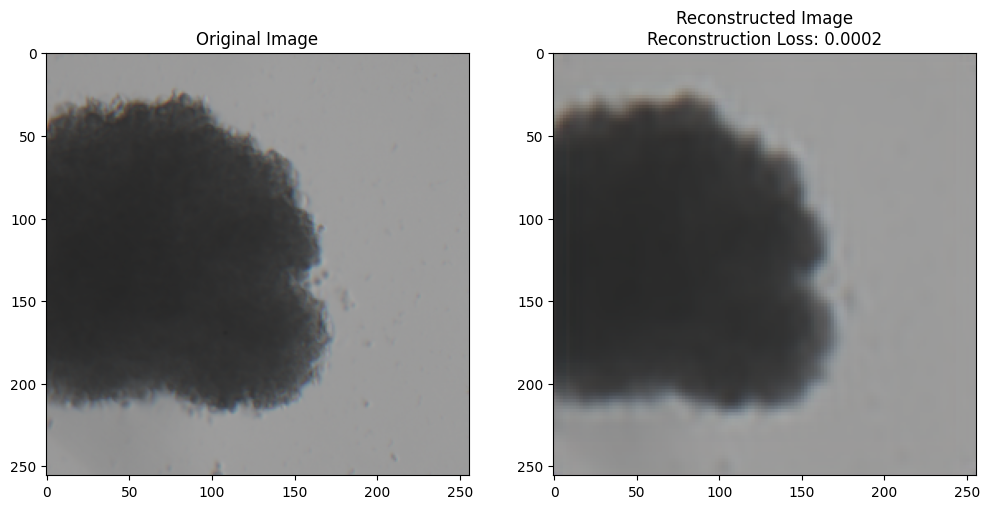

In [15]:
# Testing on a batch of images
data_batch = next(iter(inference_loader))
images = data_batch
modi.eval()
with torch.no_grad():
    outputs = modi(images)

# Randomly select an image from the batch
image_number = random.randint(0, outputs.shape[0] - 1)

# Calculate the reconstruction loss for the selected image
single_image_loss = criterion(outputs[image_number].unsqueeze(0), images[image_number].unsqueeze(0)).item()

# Display original and reconstructed images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(121)
plt.title(f'Original Image')
plt.imshow(np.transpose(images[image_number].numpy(), (1, 2, 0)))

# Reconstructed image
plt.subplot(122)
plt.title(f'Reconstructed Image\nReconstruction Loss: {single_image_loss:.4f}')
plt.imshow(np.transpose(outputs[image_number].numpy(), (1, 2, 0)))

plt.show()


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super(ResNetAutoencoder, self).__init__()
        
        # Load a pre-trained ResNet-18 model
        resnet = resnet18(pretrained=True)
        
        # Freeze the encoder weights if desired
        # for param in resnet.parameters():
        #     param.requires_grad = False
        
        # Encoder: Use the first four layers of ResNet-18
        self.encoder = nn.Sequential(
            resnet.conv1,   # Output: (batch_size, 64, 112, 112)
            resnet.bn1,
            resnet.relu,
            resnet.maxpool, # Output: (batch_size, 64, 56, 56)
            resnet.layer1,  # Output: (batch_size, 64, 56, 56)
            resnet.layer2,  # Output: (batch_size, 128, 28, 28)
            resnet.layer3,  # Output: (batch_size, 256, 14, 14)
            resnet.layer4   # Output: (batch_size, 512, 7, 7)
        )
        
        # Bottleneck layer: Single convolutional layer
        self.bottleneck = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        # Decoder layers: Upsample and reduce channels
        self.decoder = nn.Sequential(
            # Upsample 7x7 -> 14x14
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            self.conv_block(512, 256),  # 512 -> 256 channels
            
            # Upsample 14x14 -> 28x28
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            self.conv_block(256, 128),  # 256 -> 128 channels
            
            # Upsample 28x28 -> 56x56
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            self.conv_block(128, 64),   # 128 -> 64 channels
            
            # Upsample 56x56 -> 112x112
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            self.conv_block(64, 32),    # 64 -> 32 channels
            
            # Upsample 112x112 -> 224x224
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            self.conv_block(32, 16),    # 32 -> 16 channels
            
            # Final convolutional layer to reduce channels to 3
            nn.Conv2d(16, 3, kernel_size=5, stride=1, padding=2, bias=False),
            nn.Sigmoid()  # Ensure output values are in [0, 1]
        )
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 
                      kernel_size=5, stride=1,
                      padding=2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        # Bottleneck
        x = self.bottleneck(x)
        # Decoder
        x = self.decoder(x)
        return x

'''# Example usage:
if __name__ == '__main__':
    # Initialize the model
    model = ResNetAutoencoder()
    
    # Create a dummy input tensor with shape (batch_size, channels, height, width)
    dummy_input = torch.randn(1, 3, 224, 224)
    
    # Forward pass
    output = model(dummy_input)
    
    # Check output shape
    print(f"Output shape: {output.shape}")  # Should be [1, 3, 224, 224]'''


'# Example usage:\nif __name__ == \'__main__\':\n    # Initialize the model\n    model = ResNetAutoencoder()\n    \n    # Create a dummy input tensor with shape (batch_size, channels, height, width)\n    dummy_input = torch.randn(1, 3, 224, 224)\n    \n    # Forward pass\n    output = model(dummy_input)\n    \n    # Check output shape\n    print(f"Output shape: {output.shape}")  # Should be [1, 3, 224, 224]'

In [5]:
# Ensure that your model is moved to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetAutoencoder().to(device)  # Move model to the device
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Training and validation loop
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs=1):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        
        # Training phase
        model.train()
        train_loss = 0
        for images in train_loader:
            images = images.to(device)  # Move input data to the same device
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                images = images.to(device)  # Move input data to the same device
                outputs = model(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        end_time = time.time()  # End time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch duration

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    return train_losses, val_losses

c:\Users\k54739\.conda\envs\master\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\k54739\.conda\envs\master\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
train_losses, val_losses = train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs=1) 

Epoch [1/1], Train Loss: 0.0253, Validation Loss: 0.1348, Time: 21.20 seconds


In [7]:
train_losses, val_losses = train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs=50) 

Epoch [1/50], Train Loss: 0.0100, Validation Loss: 0.0226, Time: 20.80 seconds
Epoch [2/50], Train Loss: 0.0071, Validation Loss: 0.0174, Time: 21.57 seconds
Epoch [3/50], Train Loss: 0.0065, Validation Loss: 0.0093, Time: 21.48 seconds
Epoch [4/50], Train Loss: 0.0057, Validation Loss: 0.0053, Time: 25.50 seconds
Epoch [5/50], Train Loss: 0.0059, Validation Loss: 0.0057, Time: 21.43 seconds
Epoch [6/50], Train Loss: 0.0061, Validation Loss: 0.0049, Time: 21.70 seconds
Epoch [7/50], Train Loss: 0.0047, Validation Loss: 0.0058, Time: 20.62 seconds
Epoch [8/50], Train Loss: 0.0050, Validation Loss: 0.0053, Time: 20.75 seconds
Epoch [9/50], Train Loss: 0.0051, Validation Loss: 0.0038, Time: 20.62 seconds
Epoch [10/50], Train Loss: 0.0042, Validation Loss: 0.0034, Time: 21.25 seconds
Epoch [11/50], Train Loss: 0.0042, Validation Loss: 0.0030, Time: 20.88 seconds
Epoch [12/50], Train Loss: 0.0041, Validation Loss: 0.0053, Time: 20.58 seconds
Epoch [13/50], Train Loss: 0.0036, Validation Los

In [11]:
class AutoencoderWithReducedComplexity(nn.Module):
    def __init__(self):
        super(AutoencoderWithReducedComplexity, self).__init__()
        
        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, padding='same')   # 3 -> 16 channels
        self.enc_bn1 = nn.BatchNorm2d(16)
        self.enc_pool1 = nn.MaxPool2d(2, stride=2, padding=0)              # Downsample to H/2, W/2
        
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, padding='same')  # 16 -> 32 channels
        self.enc_bn2 = nn.BatchNorm2d(32)
        self.enc_pool2 = nn.MaxPool2d(2, stride=2, padding=0)              # Downsample to H/4, W/4
        
        self.enc_conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')  # 32 -> 64 channels
        self.enc_bn3 = nn.BatchNorm2d(64)
        # No further pooling; this is the bottleneck

        # Decoder
        self.dec_up1 = nn.Upsample(scale_factor=2, mode='nearest')         # Upsample to H/2, W/2
        self.dec_conv1 = nn.Conv2d(64 + 32, 32, kernel_size=3, padding='same')  # 96 -> 32 channels
        self.dec_bn1 = nn.BatchNorm2d(32)
        
        self.dec_up2 = nn.Upsample(scale_factor=2, mode='nearest')         # Upsample to H, W
        self.dec_conv2 = nn.Conv2d(32 + 16, 16, kernel_size=3, padding='same')  # 48 -> 16 channels
        self.dec_bn2 = nn.BatchNorm2d(16)

        self.final_conv = nn.Conv2d(16, 3, kernel_size=3, padding='same')  # 16 -> 3 channels
        self.final_activation = nn.Sigmoid()
        
    def forward(self, x):
        # Encoder
        x1 = F.relu(self.enc_bn1(self.enc_conv1(x)))      # x1: [batch_size, 16, H, W]
        x1p = self.enc_pool1(x1)                          # x1p: [batch_size, 16, H/2, W/2]
        
        x2 = F.relu(self.enc_bn2(self.enc_conv2(x1p)))    # x2: [batch_size, 32, H/2, W/2]
        x2p = self.enc_pool2(x2)                          # x2p: [batch_size, 32, H/4, W/4]
        
        x3 = F.relu(self.enc_bn3(self.enc_conv3(x2p)))    # x3: [batch_size, 64, H/4, W/4]
        # x3 is the bottleneck; no further pooling
        
        # Decoder
        d1 = self.dec_up1(x3)                             # Upsample x3 to [batch_size, 64, H/2, W/2]
        d1 = torch.cat([d1, x2], dim=1)                   # Concatenate with x2: [batch_size, 64+32=96, H/2, W/2]
        d1 = F.relu(self.dec_bn1(self.dec_conv1(d1)))     # Output: [batch_size, 32, H/2, W/2]
        
        d2 = self.dec_up2(d1)                             # Upsample d1 to [batch_size, 32, H, W]
        d2 = torch.cat([d2, x1], dim=1)                   # Concatenate with x1: [batch_size, 32+16=48, H, W]
        d2 = F.relu(self.dec_bn2(self.dec_conv2(d2)))     # Output: [batch_size, 16, H, W]
        
        out = self.final_conv(d2)                         # Output: [batch_size, 3, H, W]
        out = self.final_activation(out)                  # Ensure output values are in [0, 1]
        return out

# Example usage:
# Initialize the model
model = AutoencoderWithReducedComplexity()

# Create a dummy input tensor with the shape (batch_size, channels, height, width)
dummy_input = torch.randn(1, 3, 256, 256)

# Forward pass
output = model(dummy_input)

# Check output shape
print(f"Output shape: {output.shape}")  # Should be [1, 3, 256, 256]


Output shape: torch.Size([1, 3, 256, 256])


In [12]:
# Ensure that your model is moved to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unetmodi = AutoencoderWithReducedComplexity().to(device)  # Move model to the device
criterion = nn.MSELoss()
optimizer = optim.Adam(unetmodi.parameters(), lr=0.001)


# Training and validation loop
def train_and_validate(unetmodi, train_loader, val_loader, optimizer, criterion, num_epochs=1):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        
        # Training phase
        unetmodi.train()
        train_loss = 0
        for images in train_loader:
            images = images.to(device)  # Move input data to the same device
            optimizer.zero_grad()
            outputs = unetmodi(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        unetmodi.eval()
        val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                images = images.to(device)  # Move input data to the same device
                outputs = unetmodi(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        end_time = time.time()  # End time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch duration

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    return train_losses, val_losses

In [13]:
train_losses, val_losses = train_and_validate(unetmodi, train_loader, val_loader, optimizer, criterion, num_epochs=50) #unet modi upto 64

Epoch [1/50], Train Loss: 0.0146, Validation Loss: 0.0248, Time: 20.57 seconds
Epoch [2/50], Train Loss: 0.0030, Validation Loss: 0.0189, Time: 20.57 seconds
Epoch [3/50], Train Loss: 0.0022, Validation Loss: 0.0132, Time: 19.75 seconds
Epoch [4/50], Train Loss: 0.0011, Validation Loss: 0.0073, Time: 19.32 seconds
Epoch [5/50], Train Loss: 0.0011, Validation Loss: 0.0038, Time: 19.80 seconds
Epoch [6/50], Train Loss: 0.0010, Validation Loss: 0.0029, Time: 19.52 seconds
Epoch [7/50], Train Loss: 0.0013, Validation Loss: 0.0014, Time: 19.53 seconds
Epoch [8/50], Train Loss: 0.0010, Validation Loss: 0.0007, Time: 20.01 seconds
Epoch [9/50], Train Loss: 0.0013, Validation Loss: 0.0006, Time: 20.11 seconds
Epoch [10/50], Train Loss: 0.0012, Validation Loss: 0.0007, Time: 20.00 seconds
Epoch [11/50], Train Loss: 0.0015, Validation Loss: 0.0014, Time: 20.15 seconds
Epoch [12/50], Train Loss: 0.0009, Validation Loss: 0.0004, Time: 19.70 seconds
Epoch [13/50], Train Loss: 0.0016, Validation Los

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AutoencoderWithSkipConnections(nn.Module):
    def __init__(self):
        super(AutoencoderWithSkipConnections, self).__init__()
        
        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, padding='same')
        self.enc_bn1 = nn.BatchNorm2d(16)
        self.enc_pool1 = nn.MaxPool2d(2, stride=2, padding=0)  # Changed padding to 0
        
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, padding='same')
        self.enc_bn2 = nn.BatchNorm2d(32)
        self.enc_pool2 = nn.MaxPool2d(2, stride=2, padding=0)  # Changed padding to 0
        
        self.enc_conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.enc_bn3 = nn.BatchNorm2d(64)
        self.enc_pool3 = nn.MaxPool2d(2, stride=2, padding=0)
        
        self.enc_conv4 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.enc_bn4 = nn.BatchNorm2d(128)
        self.enc_pool4 = nn.MaxPool2d(2, stride=2, padding=0)
        
        # Decoder
        self.dec_up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec_conv1 = nn.Conv2d(128 + 128, 128, kernel_size=3, padding='same')
        self.dec_bn1 = nn.BatchNorm2d(128)
        
        self.dec_up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec_conv2 = nn.Conv2d(128 + 64, 64, kernel_size=3, padding='same')
        self.dec_bn2 = nn.BatchNorm2d(64)
        
        self.dec_up3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec_conv3 = nn.Conv2d(64 + 32, 32, kernel_size=3, padding='same')
        self.dec_bn3 = nn.BatchNorm2d(32)
        
        self.dec_up4 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec_conv4 = nn.Conv2d(32 + 16, 16, kernel_size=3, padding='same')
        self.dec_bn4 = nn.BatchNorm2d(16)
        
        self.final_conv = nn.Conv2d(16, 3, kernel_size=3, padding='same')
        self.final_activation = nn.Sigmoid()
        
    def forward(self, x):
        # Encoder
        #print(f"Input: {x.shape}")
        x1 = F.relu(self.enc_bn1(self.enc_conv1(x)))      # x1: [batch_size, 16, H, W]
        #print(f"After enc_conv1 & enc_bn1: {x1.shape}")
        x1p = self.enc_pool1(x1)                          # x1p: [batch_size, 16, H/2, W/2]
        #print(f"After enc_pool1: {x1p.shape}")
        
        x2 = F.relu(self.enc_bn2(self.enc_conv2(x1p)))    # x2: [batch_size, 32, H/2, W/2]
        #print(f"After enc_conv2 & enc_bn2: {x2.shape}")
        x2p = self.enc_pool2(x2)                          # x2p: [batch_size, 32, H/4, W/4]
        #print(f"After enc_pool2: {x2p.shape}")
        
        x3 = F.relu(self.enc_bn3(self.enc_conv3(x2p)))    # x3: [batch_size, 64, H/4, W/4]
        #print(f"After enc_conv3 & enc_bn3: {x3.shape}")
        x3p = self.enc_pool3(x3)                          # x3p: [batch_size, 64, H/8, W/8]
        #print(f"After enc_pool3: {x3p.shape}")
        
        x4 = F.relu(self.enc_bn4(self.enc_conv4(x3p)))    # x4: [batch_size, 128, H/8, W/8]
        #print(f"After enc_conv4 & enc_bn4: {x4.shape}")
        x4p = self.enc_pool4(x4)                          # x4p: [batch_size, 128, H/16, W/16]
        #print(f"After enc_pool4: {x4p.shape}")
        
        # Decoder
        d1 = self.dec_up1(x4p)                            # Upsample x4p
        #print(f"After dec_up1: {d1.shape}")
        d1 = torch.cat([d1, x4], dim=1)                   # Concatenate with x4
        #print(f"After concatenation with x4: {d1.shape}")
        d1 = F.relu(self.dec_bn1(self.dec_conv1(d1)))     # Output: [batch_size, 128, H/8, W/8]
        #print(f"After dec_conv1 & dec_bn1: {d1.shape}")
        
        d2 = self.dec_up2(d1)                             # Upsample d1
        #print(f"After dec_up2: {d2.shape}")
        d2 = torch.cat([d2, x3], dim=1)                   # Concatenate with x3
        #print(f"After concatenation with x3: {d2.shape}")
        d2 = F.relu(self.dec_bn2(self.dec_conv2(d2)))     # Output: [batch_size, 64, H/4, W/4]
        #print(f"After dec_conv2 & dec_bn2: {d2.shape}")
        
        d3 = self.dec_up3(d2)                             # Upsample d2
        #print(f"After dec_up3: {d3.shape}")
        d3 = torch.cat([d3, x2], dim=1)                   # Concatenate with x2
        #print(f"After concatenation with x2: {d3.shape}")
        d3 = F.relu(self.dec_bn3(self.dec_conv3(d3)))     # Output: [batch_size, 32, H/2, W/2]
        #print(f"After dec_conv3 & dec_bn3: {d3.shape}")
        
        d4 = self.dec_up4(d3)                             # Upsample d3
        #print(f"After dec_up4: {d4.shape}")
        d4 = torch.cat([d4, x1], dim=1)                   # Concatenate with x1
        #print(f"After concatenation with x1: {d4.shape}")
        d4 = F.relu(self.dec_bn4(self.dec_conv4(d4)))     # Output: [batch_size, 16, H, W]
        #print(f"After dec_conv4 & dec_bn4: {d4.shape}")
        
        out = self.final_conv(d4)                         # Output: [batch_size, 3, H, W]
        #print(f"After final_conv: {out.shape}")
        out = self.final_activation(out)                  # Ensure output values are in [0, 1]
        #print(f"After final_activation: {out.shape}")
        return out

# Example usage:
# Initialize the model
model = AutoencoderWithSkipConnections()

# Create a dummy input tensor with the shape (batch_size, channels, height, width)
dummy_input = torch.randn(1, 3, 256, 256)

# Forward pass
output = model(dummy_input)


In [5]:
# Create a dummy input tensor
dummy_input = torch.randn(1, 3, 256, 256)

# Forward pass
output = model(dummy_input)

# Check the output shape
print(f"Output shape: {output.shape}")  # Should be [1, 3, 256, 256]


Output shape: torch.Size([1, 3, 256, 256])


In [6]:
# Ensure that your model is moved to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unetmodi = AutoencoderWithSkipConnections().to(device)  # Move model to the device
criterion = nn.MSELoss()
optimizer = optim.Adam(unetmodi.parameters(), lr=0.001)


# Training and validation loop
def train_and_validate(unetmodi, train_loader, val_loader, optimizer, criterion, num_epochs=1):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        
        # Training phase
        unetmodi.train()
        train_loss = 0
        for images in train_loader:
            images = images.to(device)  # Move input data to the same device
            optimizer.zero_grad()
            outputs = unetmodi(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        unetmodi.eval()
        val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                images = images.to(device)  # Move input data to the same device
                outputs = unetmodi(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        end_time = time.time()  # End time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch duration

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    return train_losses, val_losses

In [8]:
train_losses, val_losses = train_and_validate(unetmodi, train_loader, val_loader, optimizer, criterion, num_epochs=50) #unet modi upto 128

Epoch [1/50], Train Loss: 0.0115, Validation Loss: 0.0267, Time: 20.38 seconds
Epoch [2/50], Train Loss: 0.0018, Validation Loss: 0.0152, Time: 19.60 seconds
Epoch [3/50], Train Loss: 0.0017, Validation Loss: 0.0093, Time: 19.43 seconds
Epoch [4/50], Train Loss: 0.0011, Validation Loss: 0.0048, Time: 19.78 seconds
Epoch [5/50], Train Loss: 0.0013, Validation Loss: 0.0023, Time: 19.78 seconds
Epoch [6/50], Train Loss: 0.0011, Validation Loss: 0.0011, Time: 19.08 seconds
Epoch [7/50], Train Loss: 0.0010, Validation Loss: 0.0010, Time: 19.46 seconds
Epoch [8/50], Train Loss: 0.0008, Validation Loss: 0.0006, Time: 19.32 seconds
Epoch [9/50], Train Loss: 0.0006, Validation Loss: 0.0006, Time: 19.15 seconds
Epoch [10/50], Train Loss: 0.0010, Validation Loss: 0.0009, Time: 19.29 seconds
Epoch [11/50], Train Loss: 0.0010, Validation Loss: 0.0009, Time: 19.44 seconds
Epoch [12/50], Train Loss: 0.0011, Validation Loss: 0.0009, Time: 19.75 seconds
Epoch [13/50], Train Loss: 0.0007, Validation Los

In [9]:
train_losses, val_losses = train_and_validate(unetmodi, train_loader, val_loader, optimizer, criterion, num_epochs=350)

Epoch [1/350], Train Loss: 0.0008, Validation Loss: 0.0027, Time: 19.98 seconds
Epoch [2/350], Train Loss: 0.0005, Validation Loss: 0.0005, Time: 19.49 seconds
Epoch [3/350], Train Loss: 0.0008, Validation Loss: 0.0008, Time: 19.58 seconds
Epoch [4/350], Train Loss: 0.0005, Validation Loss: 0.0006, Time: 19.93 seconds
Epoch [5/350], Train Loss: 0.0004, Validation Loss: 0.0002, Time: 19.37 seconds


KeyboardInterrupt: 

import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetAutoencoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetAutoencoder, self).__init__()
        
        # Encoder (Contracting Path)
        self.enc1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)  # 256 -> 128
        self.enc2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)  # 128 -> 64
        self.enc3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)  # 64 -> 32
        self.enc4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)  # 32 -> 16

        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)

        # Decoder (Expansive Path)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)  # 16 -> 32
        self.dec4 = self.double_conv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)   # 32 -> 64
        self.dec3 = self.double_conv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)   # 64 -> 128
        self.dec2 = self.double_conv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)    # 128 -> 256
        self.dec1 = self.double_conv(128, 64)

        # Final Convolution
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.final_activation = nn.Sigmoid()  # Ensure output is between 0 and 1

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # Preserve spatial dimensions
            nn.BatchNorm2d(out_channels),  # Optional: Batch normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),  # Preserve spatial dimensions
            nn.BatchNorm2d(out_channels),  # Optional: Batch normalization
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))

        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)  # Skip connection
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        # Final Output
        out = self.final_conv(dec1)
        out = self.final_activation(out)
        return out

# Example usage:
# Initialize U-Net Autoencoder with 3 input channels (RGB image)
model = UNetAutoencoder(in_channels=3, out_channels=3)
print(model)


# Initialize the model
model = UNetAutoencoder()

# Create a dummy input tensor with the shape (batch_size, channels, height, width)
dummy_input = torch.randn(1, 3, 256, 256)

# Forward pass
output = model(dummy_input)

# Check output shape
print(f"Output shape: {output.shape}")  # Should be (1, 3, 256, 256)


class UNetAutoencoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetAutoencoder, self).__init__()
        
        # Encoder (Contracting Path)
        self.enc1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)  # Downsample by a factor of 2
        self.enc2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)

        # Decoder (Expansive Path)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.double_conv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.double_conv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.double_conv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.double_conv(128, 64)

        # Final Convolution
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.final_activation = nn.Sigmoid()  # Ensures output values are in [0, 1]

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Optional: Batch normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Optional: Batch normalization
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        print(f"Input: {x.shape}")
        enc1 = self.enc1(x)
        print(f"After enc1: {enc1.shape}")
        enc1_pool = self.pool1(enc1)
        print(f"After pool1: {enc1_pool.shape}")
        enc2 = self.enc2(enc1_pool)
        print(f"After enc2: {enc2.shape}")
        enc2_pool = self.pool2(enc2)
        print(f"After pool2: {enc2_pool.shape}")
        enc3 = self.enc3(enc2_pool)
        print(f"After enc3: {enc3.shape}")
        enc3_pool = self.pool3(enc3)
        print(f"After pool3: {enc3_pool.shape}")
        enc4 = self.enc4(enc3_pool)
        print(f"After enc4: {enc4.shape}")
        enc4_pool = self.pool4(enc4)
        print(f"After pool4: {enc4_pool.shape}")

        # Bottleneck
        bottleneck = self.bottleneck(enc4_pool)
        print(f"After bottleneck: {bottleneck.shape}")

        # Decoder
        dec4 = self.upconv4(bottleneck)
        print(f"After upconv4: {dec4.shape}")
        dec4 = torch.cat((dec4, enc4), dim=1)
        print(f"After concatenation with enc4: {dec4.shape}")
        dec4 = self.dec4(dec4)
        print(f"After dec4: {dec4.shape}")

        dec3 = self.upconv3(dec4)
        print(f"After upconv3: {dec3.shape}")
        dec3 = torch.cat((dec3, enc3), dim=1)
        print(f"After concatenation with enc3: {dec3.shape}")
        dec3 = self.dec3(dec3)
        print(f"After dec3: {dec3.shape}")

        dec2 = self.upconv2(dec3)
        print(f"After upconv2: {dec2.shape}")
        dec2 = torch.cat((dec2, enc2), dim=1)
        print(f"After concatenation with enc2: {dec2.shape}")
        dec2 = self.dec2(dec2)
        print(f"After dec2: {dec2.shape}")

        dec1 = self.upconv1(dec2)
        print(f"After upconv1: {dec1.shape}")
        dec1 = torch.cat((dec1, enc1), dim=1)
        print(f"After concatenation with enc1: {dec1.shape}")
        dec1 = self.dec1(dec1)
        print(f"After dec1: {dec1.shape}")

        # Final Output
        out = self.final_conv(dec1)
        print(f"After final_conv: {out.shape}")
        out = self.final_activation(out)
        print(f"After final_activation: {out.shape}")
        return out

# Example usage:
# Initialize the model
model = UNetAutoencoder(in_channels=3, out_channels=3)

# Create a dummy input tensor with the shape (batch_size, channels, height, width)
# For example, batch_size=1, channels=3, height=256, width=256
dummy_input = torch.randn(1, 3, 256, 256)

# Forward pass
output = model(dummy_input)

# Ensure that your model is moved to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UNetAutoencoder().to(device)  # Move model to the device
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training and validation loop
def train_and_validate(unet, train_loader, val_loader, optimizer, criterion, num_epochs=1):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        
        # Training phase
        unet.train()
        train_loss = 0
        for images in train_loader:
            images = images.to(device)  # Move input data to the same device
            optimizer.zero_grad()
            outputs = unet(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        unet.eval()
        val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                images = images.to(device)  # Move input data to the same device
                outputs = unet(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        end_time = time.time()  # End time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch duration

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    return train_losses, val_losses

train_losses, val_losses = train_and_validate(unet, train_loader, val_loader, optimizer, criterion, num_epochs=50)

In [7]:
class Autoencod_fituning(nn.Module):
    def __init__(self):
        super(Autoencod_fituning, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding='same'),  
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),       
            
            nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),       
            
            nn.Conv2d(32, 64, kernel_size=3, padding='same'), 
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0),

            #nn.Conv2d(64,128, kernel_size=3, padding='same'), # 
            #nn.ReLU(),
            #nn.MaxPool2d(2, stride=2, padding=0)          #128,32,32
        )

        # Decoder
        self.decoder = nn.Sequential(
            #nn.Conv2d(128, 64, kernel_size=3, padding='same'), #
            #nn.ReLU(),
            #nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, kernel_size=3, padding='same'), 
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),    
    
            nn.Conv2d(32, 16, kernel_size=3, padding='same'), 
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),      
    
            nn.Conv2d(16, 3, kernel_size=3, padding='same'),  
            nn.Upsample(scale_factor=2, mode='nearest'),      
            nn.Sigmoid()                                      # Ensures output values are in [0, 1] range
        )
        
    def forward(self, x):
        #print("Input:", x.shape)
        
        # Encoder
        for layer in self.encoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        # Decoder
        for layer in self.decoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        return x


modi = Autoencod_fituning()
criterion = nn.MSELoss()
optimizer = optim.Adam(modi.parameters(), lr=0.001)


In [8]:
# Ensure that your model is moved to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modi = Autoencod_fituning().to(device)  # Move model to the device
criterion = nn.MSELoss()
optimizer = optim.Adam(modi.parameters(), lr=0.001)


# Training and validation loop
def train_and_validate(modi, train_loader, val_loader, optimizer, criterion, num_epochs=1):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        
        # Training phase
        modi.train()
        train_loss = 0
        for images in train_loader:
            images = images.to(device)  # Move input data to the same device
            optimizer.zero_grad()
            outputs = modi(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        modi.eval()
        val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                images = images.to(device)  # Move input data to the same device
                outputs = modi(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        end_time = time.time()  # End time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch duration

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    return train_losses, val_losses

In [ ]:
train_losses, val_losses = train_and_validate(modi, train_loader, val_loader, optimizer, criterion, num_epochs=50)

Epoch [1/50], Train Loss: 0.0412, Validation Loss: 0.0373, Time: 19.48 seconds
Epoch [2/50], Train Loss: 0.0331, Validation Loss: 0.0207, Time: 19.10 seconds
Epoch [3/50], Train Loss: 0.0124, Validation Loss: 0.0116, Time: 19.32 seconds
Epoch [4/50], Train Loss: 0.0071, Validation Loss: 0.0043, Time: 19.48 seconds


In [50]:
train_losses, val_losses = train_and_validate(modi, train_loader, val_loader, optimizer, criterion, num_epochs=500)

Epoch [1/500], Train Loss: 0.0071, Validation Loss: 0.0052, Time: 2.14 seconds
Epoch [2/500], Train Loss: 0.0042, Validation Loss: 0.0037, Time: 2.17 seconds
Epoch [3/500], Train Loss: 0.0030, Validation Loss: 0.0030, Time: 2.34 seconds
Epoch [4/500], Train Loss: 0.0024, Validation Loss: 0.0025, Time: 2.35 seconds
Epoch [5/500], Train Loss: 0.0021, Validation Loss: 0.0022, Time: 2.32 seconds
Epoch [6/500], Train Loss: 0.0020, Validation Loss: 0.0020, Time: 2.38 seconds
Epoch [7/500], Train Loss: 0.0018, Validation Loss: 0.0018, Time: 2.31 seconds
Epoch [8/500], Train Loss: 0.0017, Validation Loss: 0.0022, Time: 2.39 seconds
Epoch [9/500], Train Loss: 0.0015, Validation Loss: 0.0015, Time: 2.34 seconds
Epoch [10/500], Train Loss: 0.0013, Validation Loss: 0.0014, Time: 2.35 seconds
Epoch [11/500], Train Loss: 0.0012, Validation Loss: 0.0014, Time: 2.39 seconds
Epoch [12/500], Train Loss: 0.0012, Validation Loss: 0.0013, Time: 2.35 seconds
Epoch [13/500], Train Loss: 0.0012, Validation Lo

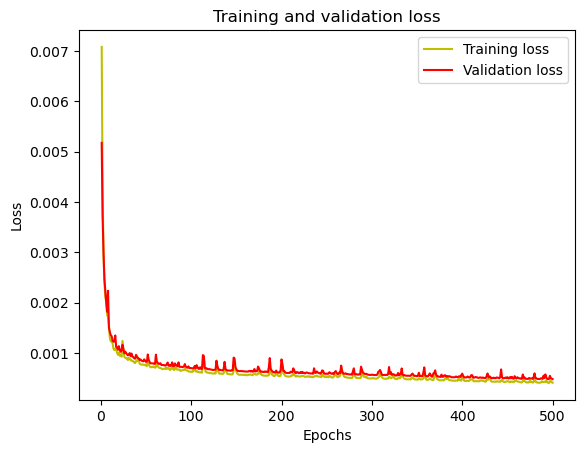

In [51]:
num_epochs = 500
# Plot training and validation loss
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'y', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




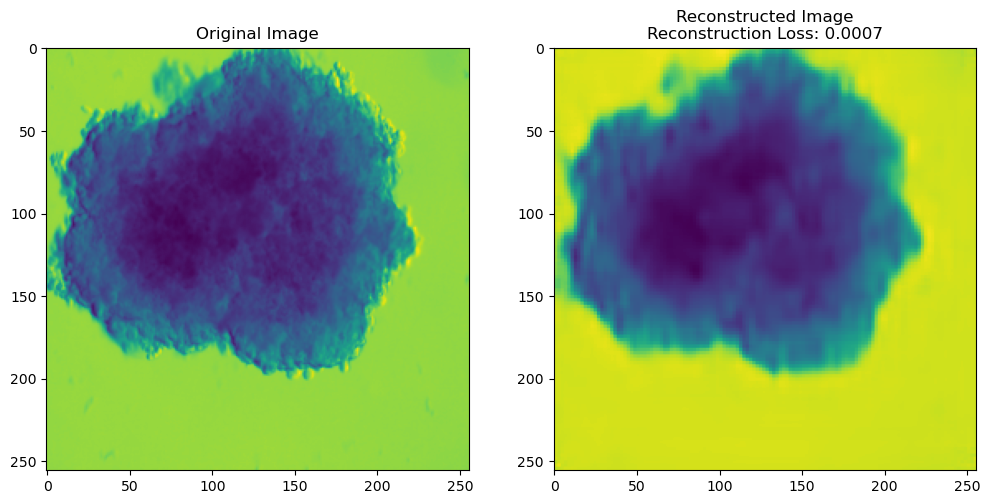

In [52]:
# Testing on a batch of images
data_batch = next(iter(train_loader))
images = data_batch
modi.eval()
with torch.no_grad():
    outputs = modi(images)

# Randomly select an image from the batch
image_number = random.randint(0, outputs.shape[0] - 1)

# Calculate the reconstruction loss for the selected image
single_image_loss = criterion(outputs[image_number].unsqueeze(0), images[image_number].unsqueeze(0)).item()

# Display original and reconstructed images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(121)
plt.title(f'Original Image')
plt.imshow(np.transpose(images[image_number].numpy(), (1, 2, 0)))

# Reconstructed image
plt.subplot(122)
plt.title(f'Reconstructed Image\nReconstruction Loss: {single_image_loss:.4f}')
plt.imshow(np.transpose(outputs[image_number].numpy(), (1, 2, 0)))

plt.show()

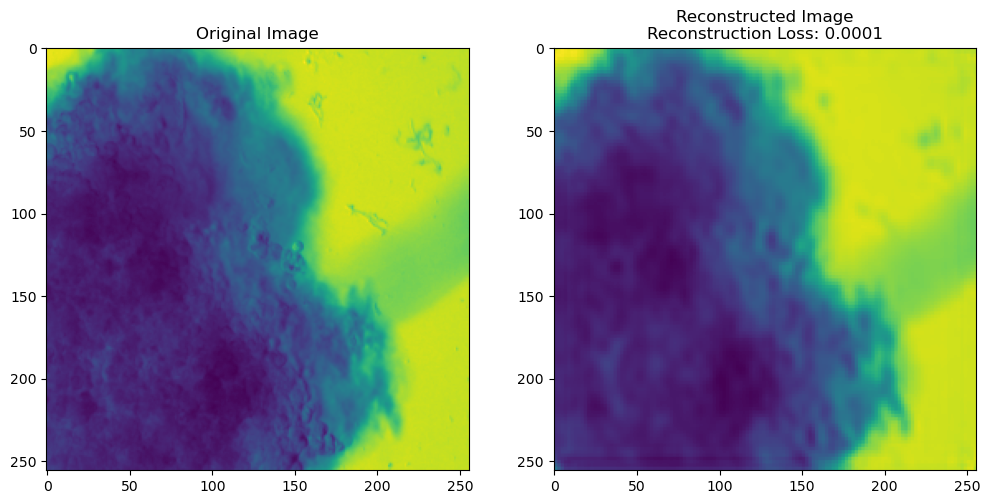

In [36]:
#single_channel_upto64 gives better reconstruction error than 128. 


# Testing on a batch of images
data_batch = next(iter(train_loader))
images = data_batch
modi.eval()
with torch.no_grad():
    outputs = modi(images)

# Randomly select an image from the batch
image_number = random.randint(0, outputs.shape[0] - 1)

# Calculate the reconstruction loss for the selected image
single_image_loss = criterion(outputs[image_number].unsqueeze(0), images[image_number].unsqueeze(0)).item()

# Display original and reconstructed images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(121)
plt.title(f'Original Image')
plt.imshow(np.transpose(images[image_number].numpy(), (1, 2, 0)))

# Reconstructed image
plt.subplot(122)
plt.title(f'Reconstructed Image\nReconstruction Loss: {single_image_loss:.4f}')
plt.imshow(np.transpose(outputs[image_number].numpy(), (1, 2, 0)))

plt.show()

In [37]:
# Save the model parameters after training
torch.save(modi.state_dict(), 'modi_single_channel.pth')


class ThreeChannel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encode = nn.Sequential(
            self._conv_block(1, 16),  # Changed input channels from 1 to 3
            self._conv_block(16, 32),
            self._conv_block(32, 64),
            #self._conv_block(64, 128),
            #self._conv_block(128, 256),
            #self._conv_block(256, 512),
        )
        
        self.decode = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear"),
            
            #self._deconv_block(512, 256, output_padding=1),
            #self._deconv_block(256, 128, output_padding=1),
            #self._deconv_block(128, 64, output_padding=1),
            self._deconv_block(64, 32, output_padding=1),
            self._deconv_block(32, 16, output_padding=1),
            
            nn.Conv2d(16, 1, kernel_size=5, stride=1, padding=5//2),  # Changed output channels from 1 to 3
            nn.Sigmoid(),
        )
        
    def _conv_block(self, in_channels, out_channels, kernel_size=5, stride=2, padding=1, leaky_slope=0.2):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(leaky_slope),
        )
        
    def _deconv_block(self, in_channels, out_channels, kernel_size=5, stride=2, padding=1, leaky_slope=0.2, output_padding=0):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=kernel_size//2),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(leaky_slope),
            nn.Upsample(scale_factor=2, mode="bilinear"),
        )
        
    def forward(self, x):
        latent = self.encode(x)
        #print(latent.shape)
        output = self.decode(latent)
        return output
    '''def forward(self, x):
        print(f"\nInput shape: {x.shape}")
    
    # Encoder
        for i, layer in enumerate(self.encode):
            x = layer(x)
            print(f"Encoder layer {i} output shape: {x.shape}")
    
        encoded = x
        print(f"\nBottleneck shape: {encoded.shape}")
    
    # Decoder
        x = encoded
        for i, layer in enumerate(self.decode):
            x = layer(x)
            print(f"Decoder layer {i} output shape: {x.shape}")
    
        decoded = x
        print(f"\nFinal output shape: {decoded.shape}\n")
    
        return decoded'''

# Optional: Print model summary to verify the changes
def print_model_summary(model):
    # Create a random input tensor with 3 channels
    sample_input = torch.randn(1, 1, 256, 256)  # Batch size 1, 3 channels, 256x256 image
    print(f"Input shape: {sample_input.shape}")
    
    # Get output shape
    output = model(sample_input)
    print(f"Output shape: {output.shape}")
    
    # Print total parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

threechannel = ThreeChannel()
print_model_summary(threechannel)

summary(threechannel, input_size=(batch_size, 3, 256, 256))

criterion = nn.MSELoss()
optimizer = optim.Adam(threechannel.parameters(), lr=0.001)

# Ensure that your model is moved to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
threechannel = ThreeChannel().to(device)  # Move model to the device

# Training and validation loop
def train_and_validate(threechannel, train_loader, val_loader, optimizer, criterion, num_epochs=1):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        
        # Training phase
        threechannel.train()
        train_loss = 0
        for images in train_loader:
            images = images.to(device)  # Move input data to the same device
            optimizer.zero_grad()
            outputs = threechannel(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        threechannel.eval()
        val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                images = images.to(device)  # Move input data to the same device
                outputs = threechannel(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        end_time = time.time()  # End time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch duration

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    return train_losses, val_losses


train_losses, val_losses = train_and_validate(threechannel, train_loader, val_loader, optimizer, criterion, num_epochs=1)

train_losses, val_losses = train_and_validate(threechannel, train_loader, val_loader, optimizer, criterion, num_epochs=350)

class Modify(nn.Module):
    def __init__(self):
        super(Modify, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding='same'),  
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),        
            
            nn.Conv2d(16, 32, kernel_size=3, padding='same'), 
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),        
            
            nn.Conv2d(32, 64, kernel_size=3, padding='same'), 
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),

            nn.Conv2d(64,128, kernel_size=3, padding='same'), 
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0)          
        )

        # Decoder with only ConvTranspose2d and ReLU layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128,64, kernel_size=2, stride=2),  # Upsample to (128, 128)
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # Upsample to (64, 64)
            nn.ReLU(),



            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # Upsample to (128, 128)
            nn.ReLU(),
    
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),   # Upsample to (256, 256)
            nn.Sigmoid()                                          # Ensures output values are in [0, 1] range
        )
        
    def forward(self, x):
        print("Input:", x.shape)
        
        # Encoder
        for layer in self.encoder:
            x = layer(x)
            print(f"After {layer}: {x.shape}")
        
        # Decoder
        for layer in self.decoder:
            x = layer(x)
            print(f"After {layer}: {x.shape}")
        
        return x

In [4]:
class Modify(nn.Module):
    def __init__(self):
        super(Modify, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding='same'),  
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),        
            
            nn.Conv2d(16, 32, kernel_size=3, padding='same'), 
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),        
            
            nn.Conv2d(32, 64, kernel_size=3, padding='same'), 
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0),       
        )

        # Decoder with only ConvTranspose2d and ReLU layers
        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # Upsample to (64, 64)
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # Upsample to (128, 128)
            nn.ReLU(),
    
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),   # Upsample to (256, 256)
            nn.Sigmoid()                                          # Ensures output values are in [0, 1] range
        )
        
    def forward(self, x):
        #print("Input:", x.shape)
        
        # Encoder
        for layer in self.encoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        # Decoder
        for layer in self.decoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        return x

In [5]:
Modify = Modify()
criterion = nn.MSELoss()
optimizer = optim.Adam(Modify.parameters(), lr=0.001)

In [6]:
def train_and_validate(Modify,train_loader, val_loader, optimizer, criterion, num_epochs=1):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        
        # Training phase
        Modify.train()
        train_loss = 0
        for images in train_loader:
            optimizer.zero_grad()
            outputs = Modify(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        Modify.eval()
        val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                outputs = Modify(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        end_time = time.time()  # End time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch duration

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    return train_losses, val_losses


In [7]:
train_losses, val_losses = train_and_validate(Modify, train_loader, val_loader, optimizer, criterion, num_epochs=1)

Epoch [1/1], Train Loss: 0.0419, Validation Loss: 0.0418, Time: 9.96 seconds


In [8]:
train_losses, val_losses = train_and_validate(Modify, train_loader, val_loader, optimizer, criterion, num_epochs=350)

Epoch [1/350], Train Loss: 0.0418, Validation Loss: 0.0392, Time: 9.94 seconds
Epoch [2/350], Train Loss: 0.0417, Validation Loss: 0.0385, Time: 9.98 seconds
Epoch [3/350], Train Loss: 0.0362, Validation Loss: 0.0320, Time: 9.96 seconds
Epoch [4/350], Train Loss: 0.0306, Validation Loss: 0.0249, Time: 9.92 seconds
Epoch [5/350], Train Loss: 0.0195, Validation Loss: 0.0143, Time: 9.93 seconds
Epoch [6/350], Train Loss: 0.0118, Validation Loss: 0.0082, Time: 9.99 seconds
Epoch [7/350], Train Loss: 0.0069, Validation Loss: 0.0048, Time: 9.99 seconds
Epoch [8/350], Train Loss: 0.0043, Validation Loss: 0.0035, Time: 9.98 seconds
Epoch [9/350], Train Loss: 0.0034, Validation Loss: 0.0027, Time: 10.00 seconds
Epoch [10/350], Train Loss: 0.0026, Validation Loss: 0.0022, Time: 9.93 seconds
Epoch [11/350], Train Loss: 0.0022, Validation Loss: 0.0019, Time: 9.98 seconds
Epoch [12/350], Train Loss: 0.0019, Validation Loss: 0.0018, Time: 9.95 seconds
Epoch [13/350], Train Loss: 0.0018, Validation L

In [9]:
train_losses, val_losses = train_and_validate(Modify, train_loader, val_loader, optimizer, criterion, num_epochs=100)

Epoch [1/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 10.27 seconds
Epoch [2/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 10.17 seconds
Epoch [3/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 10.15 seconds
Epoch [4/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 10.11 seconds
Epoch [5/100], Train Loss: 0.0004, Validation Loss: 0.0003, Time: 10.23 seconds
Epoch [6/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 10.18 seconds
Epoch [7/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 10.19 seconds
Epoch [8/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 10.18 seconds
Epoch [9/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 10.22 seconds
Epoch [10/100], Train Loss: 0.0004, Validation Loss: 0.0005, Time: 10.23 seconds
Epoch [11/100], Train Loss: 0.0005, Validation Loss: 0.0003, Time: 10.23 seconds
Epoch [12/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 10.19 seconds
Epoch [13/100], Train Loss: 0.0004, V

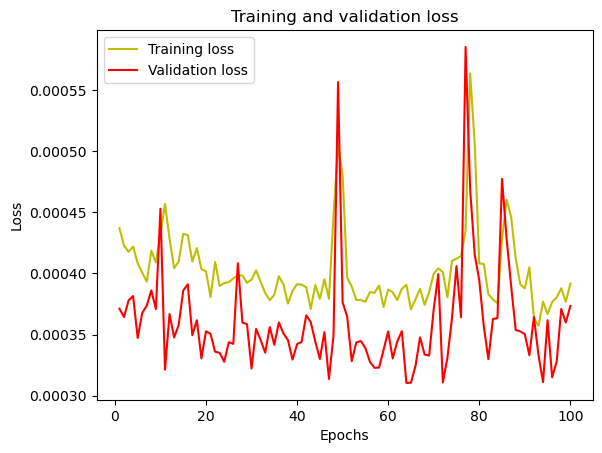

In [10]:
num_epochs = 100
# Plot training and validation loss
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'y', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


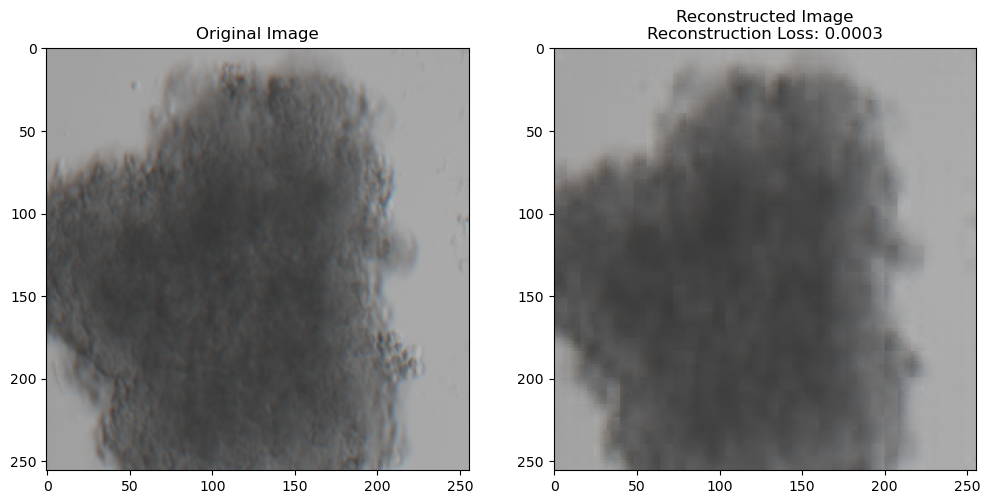

In [19]:
# Testing on a batch of images
data_batch = next(iter(train_loader))
images = data_batch
Modify.eval()
with torch.no_grad():
    outputs = Modify(images)

# Randomly select an image from the batch
image_number = random.randint(0, outputs.shape[0] - 1)

# Calculate the reconstruction loss for the selected image
single_image_loss = criterion(outputs[image_number].unsqueeze(0), images[image_number].unsqueeze(0)).item()

# Display original and reconstructed images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(121)
plt.title(f'Original Image')
plt.imshow(np.transpose(images[image_number].numpy(), (1, 2, 0)))

# Reconstructed image
plt.subplot(122)
plt.title(f'Reconstructed Image\nReconstruction Loss: {single_image_loss:.4f}')
plt.imshow(np.transpose(outputs[image_number].numpy(), (1, 2, 0)))

plt.show()


In [17]:
# Save the model parameters after training
torch.save(Modify.state_dict(), 'Modify.pth')


In [10]:
class Modi_tuned(nn.Module):
    def __init__(self):
        super(Modi_tuned, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding='same'),  # Input: (3, 96, 96) Output: (64, 96, 96)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),        # Output: (64, 48, 48)
            
            nn.Conv2d(16, 32, kernel_size=3, padding='same'), # Output: (32, 48, 48)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),        # Output: (32, 24, 24)
            
            nn.Conv2d(32, 64, kernel_size=3, padding='same'), # Output: (16, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)         # Output: (16, 12, 12)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding='same'), # Output: (32, 12, 12)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),      # Output: (32, 24, 24)
    
            nn.Conv2d(32, 16, kernel_size=3, padding='same'), # Output: (16, 24, 24)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),      # Output: (16, 48, 48)
    
            nn.Conv2d(16, 3, kernel_size=3, padding='same'),  # Output: (3, 48, 48)
            nn.Upsample(scale_factor=2, mode='nearest'),      # Output: (3, 96, 96)
            nn.Sigmoid()                                      # Ensures output values are in [0, 1] range
        )
        
    def forward(self, x):
        #print("Input:", x.shape)
        
        # Encoder
        for layer in self.encoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        # Decoder
        for layer in self.decoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        return x


In [11]:
mod_tuned = Modi_tuned()
criterion = nn.MSELoss()
optimizer = optim.Adam(mod_tuned.parameters(), lr=0.001)

In [12]:
def train_and_validate(mo, train_loader, val_loader, optimizer, criterion, num_epochs=1):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        
        # Training phase
        mod_tuned.train()
        train_loss = 0
        for images in train_loader:
            optimizer.zero_grad()
            outputs = mod_tuned(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        mod_tuned.eval()
        val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                outputs = mod_tuned(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        end_time = time.time()  # End time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch duration

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    return train_losses, val_losses


In [13]:
train_losses, val_losses = train_and_validate(mod_tuned, train_loader, val_loader, optimizer, criterion, num_epochs=1)

Epoch [1/1], Train Loss: 0.0394, Validation Loss: 0.0278, Time: 10.41 seconds


In [14]:
train_losses, val_losses = train_and_validate(mod_tuned, train_loader, val_loader, optimizer, criterion, num_epochs=350)

Epoch [1/350], Train Loss: 0.0206, Validation Loss: 0.0079, Time: 10.35 seconds
Epoch [2/350], Train Loss: 0.0075, Validation Loss: 0.0047, Time: 10.31 seconds
Epoch [3/350], Train Loss: 0.0040, Validation Loss: 0.0034, Time: 10.27 seconds
Epoch [4/350], Train Loss: 0.0026, Validation Loss: 0.0016, Time: 10.36 seconds
Epoch [5/350], Train Loss: 0.0018, Validation Loss: 0.0014, Time: 10.29 seconds
Epoch [6/350], Train Loss: 0.0016, Validation Loss: 0.0013, Time: 10.31 seconds
Epoch [7/350], Train Loss: 0.0014, Validation Loss: 0.0013, Time: 10.38 seconds
Epoch [8/350], Train Loss: 0.0013, Validation Loss: 0.0012, Time: 12.05 seconds
Epoch [9/350], Train Loss: 0.0012, Validation Loss: 0.0011, Time: 17.35 seconds
Epoch [10/350], Train Loss: 0.0012, Validation Loss: 0.0011, Time: 10.07 seconds
Epoch [11/350], Train Loss: 0.0012, Validation Loss: 0.0011, Time: 9.69 seconds
Epoch [12/350], Train Loss: 0.0011, Validation Loss: 0.0011, Time: 9.69 seconds
Epoch [13/350], Train Loss: 0.0011, Val

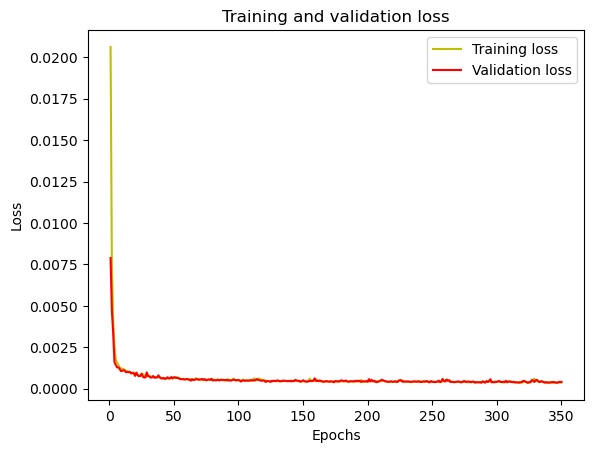

In [15]:
num_epochs = 350
# Plot training and validation loss
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'y', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


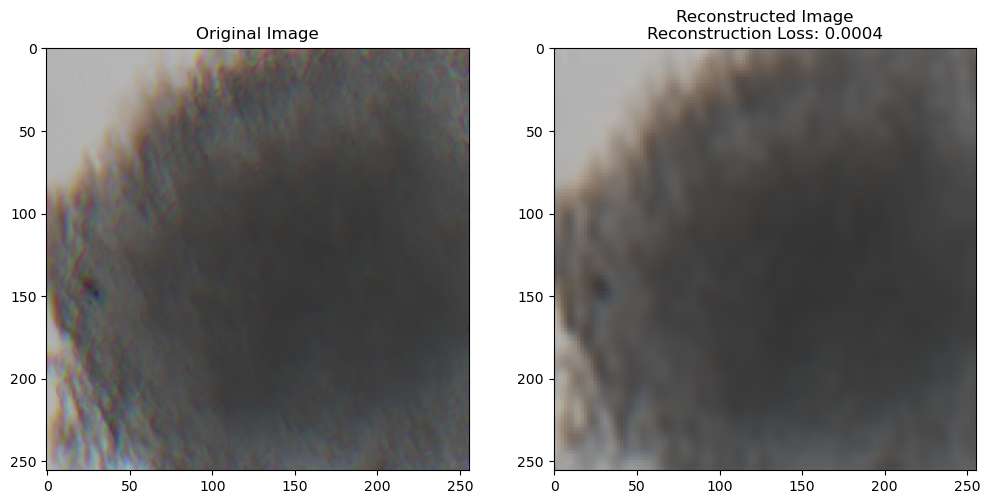

In [16]:
# Testing on a batch of images
data_batch = next(iter(train_loader))
images = data_batch
mod_tuned.eval()
with torch.no_grad():
    outputs = mod_tuned(images)

# Randomly select an image from the batch
image_number = random.randint(0, outputs.shape[0] - 1)

# Calculate the reconstruction loss for the selected image
single_image_loss = criterion(outputs[image_number].unsqueeze(0), images[image_number].unsqueeze(0)).item()

# Display original and reconstructed images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(121)
plt.title(f'Original Image')
plt.imshow(np.transpose(images[image_number].numpy(), (1, 2, 0)))

# Reconstructed image
plt.subplot(122)
plt.title(f'Reconstructed Image\nReconstruction Loss: {single_image_loss:.4f}')
plt.imshow(np.transpose(outputs[image_number].numpy(), (1, 2, 0)))

plt.show()


In [17]:
# Save the model parameters after training
torch.save(mod_tuned.state_dict(), 'mod_tuned.pth')


In [8]:
class Onetwentyeight(nn.Module):
    def __init__(self):
        super(Onetwentyeight, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding='same'),  # Input: (3, 96, 96) Output: (64, 96, 96)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),        # Output: (64, 48, 48)
            
            nn.Conv2d(16, 32, kernel_size=3, padding='same'), # Output: (32, 48, 48)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),        # Output: (32, 24, 24)
            
            nn.Conv2d(32, 64, kernel_size=3, padding='same'), # Output: (16, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),   
                        # Output: (16, 12, 12)
            nn.Conv2d(64,128, kernel_size=3, padding='same'), # Output: (16, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2) 
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding='same'), # Output: (32, 12, 12)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), 

            nn.Conv2d(64, 32, kernel_size=3, padding='same'), # Output: (32, 12, 12)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),      # Output: (32, 24, 24)
    
            nn.Conv2d(32, 16, kernel_size=3, padding='same'), # Output: (16, 24, 24)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),      # Output: (16, 48, 48)
    
            nn.Conv2d(16, 3, kernel_size=3, padding='same'),  # Output: (3, 48, 48)
            nn.Upsample(scale_factor=2, mode='nearest'),      # Output: (3, 96, 96)
            nn.Sigmoid()                                      # Ensures output values are in [0, 1] range
        )
        
    def forward(self, x):
        #print("Input:", x.shape)
        
        # Encoder
        for layer in self.encoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        # Decoder
        for layer in self.decoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        return x


In [9]:
mod_128 = Onetwentyeight()
criterion = nn.MSELoss()
optimizer = optim.Adam(mod_128.parameters(), lr=0.001)

In [10]:
def train_and_validate(mo, train_loader, val_loader, optimizer, criterion, num_epochs=1):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        
        # Training phase
        mod_128.train()
        train_loss = 0
        for images in train_loader:
            optimizer.zero_grad()
            outputs = mod_128(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        mod_128.eval()
        val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                outputs = mod_128(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        end_time = time.time()  # End time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch duration

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    return train_losses, val_losses


Epoch [1/1], Train Loss: 0.0382, Validation Loss: 0.0317, Time: 10.66 seconds


In [ ]:
train_losses, val_losses = train_and_validate(mod_128, train_loader, val_loader, optimizer, criterion, num_epochs=1)

In [11]:
train_losses, val_losses = train_and_validate(mod_128, train_loader, val_loader, optimizer, criterion, num_epochs=350)

Epoch [1/350], Train Loss: 0.0260, Validation Loss: 0.0138, Time: 10.52 seconds
Epoch [2/350], Train Loss: 0.0104, Validation Loss: 0.0078, Time: 10.53 seconds
Epoch [3/350], Train Loss: 0.0057, Validation Loss: 0.0045, Time: 10.61 seconds
Epoch [4/350], Train Loss: 0.0036, Validation Loss: 0.0034, Time: 10.52 seconds
Epoch [5/350], Train Loss: 0.0027, Validation Loss: 0.0029, Time: 10.64 seconds
Epoch [6/350], Train Loss: 0.0023, Validation Loss: 0.0023, Time: 10.56 seconds
Epoch [7/350], Train Loss: 0.0020, Validation Loss: 0.0022, Time: 11.51 seconds
Epoch [8/350], Train Loss: 0.0019, Validation Loss: 0.0020, Time: 19.15 seconds
Epoch [9/350], Train Loss: 0.0018, Validation Loss: 0.0020, Time: 19.36 seconds
Epoch [10/350], Train Loss: 0.0017, Validation Loss: 0.0019, Time: 19.32 seconds
Epoch [11/350], Train Loss: 0.0016, Validation Loss: 0.0017, Time: 19.23 seconds
Epoch [12/350], Train Loss: 0.0014, Validation Loss: 0.0015, Time: 19.52 seconds
Epoch [13/350], Train Loss: 0.0024, V

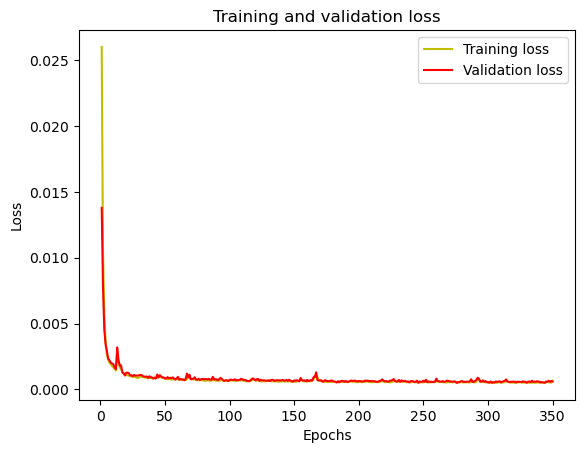

In [12]:
num_epochs = 350
# Plot training and validation loss
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'y', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


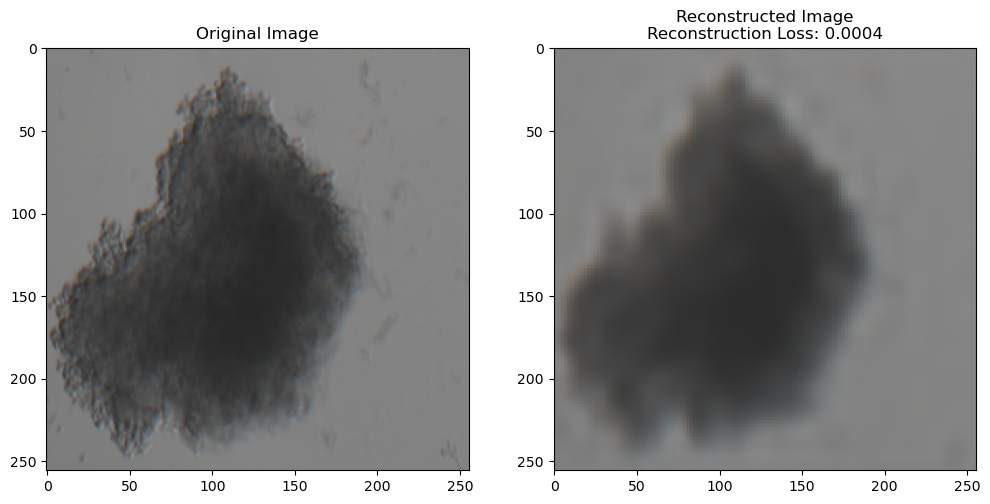

In [16]:
# Testing on a batch of images
data_batch = next(iter(train_loader))
images = data_batch
mod_128.eval()
with torch.no_grad():
    outputs = mod_128(images)

# Randomly select an image from the batch
image_number = random.randint(0, outputs.shape[0] - 1)

# Calculate the reconstruction loss for the selected image
single_image_loss = criterion(outputs[image_number].unsqueeze(0), images[image_number].unsqueeze(0)).item()

# Display original and reconstructed images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(121)
plt.title(f'Original Image')
plt.imshow(np.transpose(images[image_number].numpy(), (1, 2, 0)))

# Reconstructed image
plt.subplot(122)
plt.title(f'Reconstructed Image\nReconstruction Loss: {single_image_loss:.4f}')
plt.imshow(np.transpose(outputs[image_number].numpy(), (1, 2, 0)))

plt.show()


In [17]:
# Save the model parameters after training
torch.save(mod_128.state_dict(), 'mod_128.pth')


In [11]:
class Autoencod_fitune(nn.Module):
    def __init__(self):
        super(Autoencod_fitune, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding='same'),  # Input: (3, 96, 96) Output: (64, 96, 96)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),        # Output: (64, 48, 48)
            
            nn.Conv2d(16, 32, kernel_size=5, padding='same'), # Output: (32, 48, 48)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),        # Output: (32, 24, 24)
            
            nn.Conv2d(32, 64, kernel_size=5, padding='same'), # Output: (16, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)         # Output: (16, 12, 12)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=5, padding='same'), # Output: (32, 12, 12)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),      # Output: (32, 24, 24)
    
            nn.Conv2d(32, 16, kernel_size=5, padding='same'), # Output: (16, 24, 24)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),      # Output: (16, 48, 48)
    
            nn.Conv2d(16, 3, kernel_size=5, padding='same'),  # Output: (3, 48, 48)
            nn.Upsample(scale_factor=2, mode='nearest'),      # Output: (3, 96, 96)
            nn.Sigmoid()                                      # Ensures output values are in [0, 1] range
        )
        
    def forward(self, x):
        #print("Input:", x.shape)
        
        # Encoder
        for layer in self.encoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        # Decoder
        for layer in self.decoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        return x


In [12]:
moda = Autoencod_fitune()
criterion = nn.MSELoss()
optimizer = optim.Adam(moda.parameters(), lr=0.001)

In [13]:
def train_and_validate(mo, train_loader, val_loader, optimizer, criterion, num_epochs=1):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        
        # Training phase
        moda.train()
        train_loss = 0
        for images in train_loader:
            optimizer.zero_grad()
            outputs = moda(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        moda.eval()
        val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                outputs = moda(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        end_time = time.time()  # End time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch duration

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    return train_losses, val_losses


train_losses, val_losses = train_and_validate(moda, train_loader, val_loader, optimizer, criterion, num_epochs=1)


Epoch [1/1], Train Loss: 0.0364, Validation Loss: 0.0228, Time: 10.75 seconds


In [15]:
train_losses, val_losses = train_and_validate(moda, train_loader, val_loader, optimizer, criterion, num_epochs=350)

Epoch [1/350], Train Loss: 0.0189, Validation Loss: 0.0089, Time: 10.76 seconds
Epoch [2/350], Train Loss: 0.0060, Validation Loss: 0.0049, Time: 10.79 seconds
Epoch [3/350], Train Loss: 0.0036, Validation Loss: 0.0029, Time: 10.82 seconds
Epoch [4/350], Train Loss: 0.0028, Validation Loss: 0.0027, Time: 10.84 seconds
Epoch [5/350], Train Loss: 0.0023, Validation Loss: 0.0021, Time: 10.81 seconds
Epoch [6/350], Train Loss: 0.0021, Validation Loss: 0.0020, Time: 10.86 seconds
Epoch [7/350], Train Loss: 0.0018, Validation Loss: 0.0017, Time: 10.88 seconds
Epoch [8/350], Train Loss: 0.0016, Validation Loss: 0.0016, Time: 10.93 seconds
Epoch [9/350], Train Loss: 0.0015, Validation Loss: 0.0013, Time: 10.74 seconds
Epoch [10/350], Train Loss: 0.0013, Validation Loss: 0.0013, Time: 10.83 seconds
Epoch [11/350], Train Loss: 0.0013, Validation Loss: 0.0013, Time: 10.81 seconds
Epoch [12/350], Train Loss: 0.0020, Validation Loss: 0.0020, Time: 19.51 seconds
Epoch [13/350], Train Loss: 0.0030, V

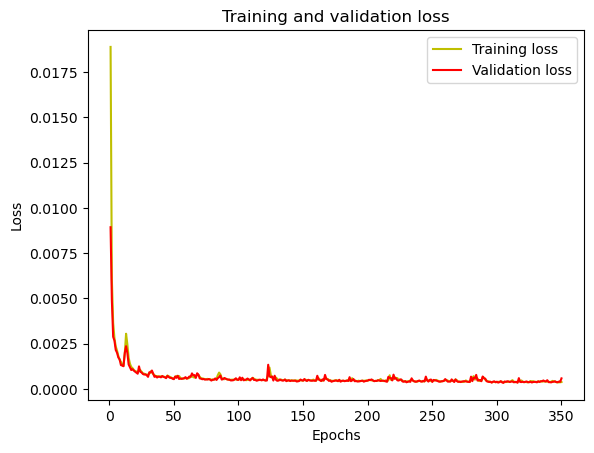

In [16]:
num_epochs = 350
# Plot training and validation loss
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'y', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


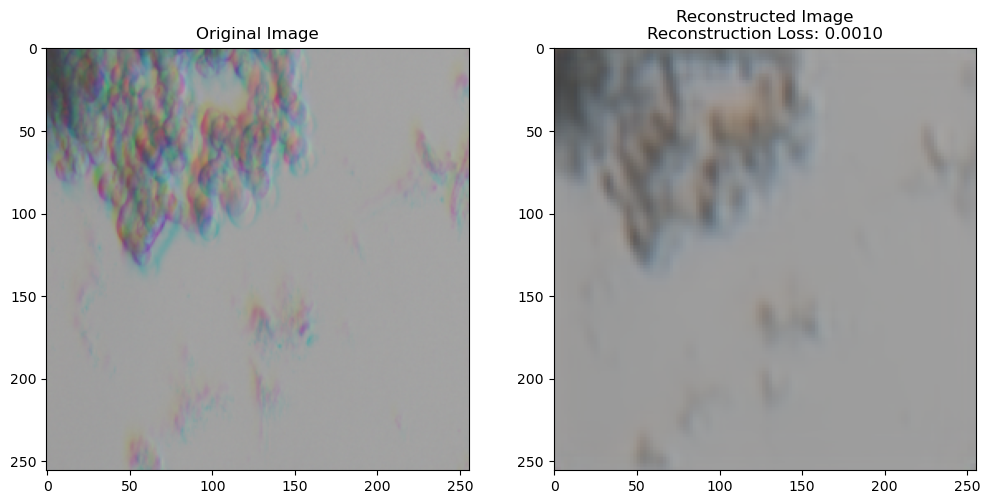

In [17]:
# Testing on a batch of images
data_batch = next(iter(train_loader))
images = data_batch
moda.eval()
with torch.no_grad():
    outputs = moda(images)

# Randomly select an image from the batch
image_number = random.randint(0, outputs.shape[0] - 1)

# Calculate the reconstruction loss for the selected image
single_image_loss = criterion(outputs[image_number].unsqueeze(0), images[image_number].unsqueeze(0)).item()

# Display original and reconstructed images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(121)
plt.title(f'Original Image')
plt.imshow(np.transpose(images[image_number].numpy(), (1, 2, 0)))

# Reconstructed image
plt.subplot(122)
plt.title(f'Reconstructed Image\nReconstruction Loss: {single_image_loss:.4f}')
plt.imshow(np.transpose(outputs[image_number].numpy(), (1, 2, 0)))

plt.show()


In [23]:
class Autoencod_fituning(nn.Module):
    def __init__(self):
        super(Autoencod_fituning, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding='same'),  # Input: (3, 96, 96) Output: (64, 96, 96)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),        # Output: (64, 48, 48)
            
            nn.Conv2d(16, 32, kernel_size=3, padding='same'), # Output: (32, 48, 48)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),        # Output: (32, 24, 24)
            
            nn.Conv2d(32, 64, kernel_size=3, padding='same'), # Output: (16, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0)         # Output: (16, 12, 12)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding='same'), # Output: (32, 12, 12)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),      # Output: (32, 24, 24)
    
            nn.Conv2d(32, 16, kernel_size=3, padding='same'), # Output: (16, 24, 24)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),      # Output: (16, 48, 48)
    
            nn.Conv2d(16, 3, kernel_size=3, padding='same'),  # Output: (3, 48, 48)
            nn.Upsample(scale_factor=2, mode='nearest'),      # Output: (3, 96, 96)
            nn.Sigmoid()                                      # Ensures output values are in [0, 1] range
        )
        
    def forward(self, x):
        #print("Input:", x.shape)
        
        # Encoder
        for layer in self.encoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        # Decoder
        for layer in self.decoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        return x


In [24]:
modi = Autoencod_fituning()
criterion = nn.MSELoss()
optimizer = optim.Adam(modi.parameters(), lr=0.001)

In [25]:
def train_and_validate(mo, train_loader, val_loader, optimizer, criterion, num_epochs=1):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        
        # Training phase
        modi.train()
        train_loss = 0
        for images in train_loader:
            optimizer.zero_grad()
            outputs = modi(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        modi.eval()
        val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                outputs = modi(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        end_time = time.time()  # End time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch duration

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    return train_losses, val_losses


train_losses, val_losses = train_and_validate(modi, train_loader, val_loader, optimizer, criterion, num_epochs=1)


Epoch [1/1], Train Loss: 0.0393, Validation Loss: 0.0373, Time: 10.58 seconds


In [ ]:
train_losses, val_losses = train_and_validate(modi, train_loader, val_loader, optimizer, criterion, num_epochs=1)

In [10]:
train_losses, val_losses = train_and_validate(modi, train_loader, val_loader, optimizer, criterion, num_epochs=350)

Epoch [1/350], Train Loss: 0.0300, Validation Loss: 0.0168, Time: 10.26 seconds
Epoch [2/350], Train Loss: 0.0096, Validation Loss: 0.0047, Time: 10.24 seconds
Epoch [3/350], Train Loss: 0.0076, Validation Loss: 0.0048, Time: 10.26 seconds
Epoch [4/350], Train Loss: 0.0050, Validation Loss: 0.0044, Time: 10.18 seconds
Epoch [5/350], Train Loss: 0.0032, Validation Loss: 0.0023, Time: 10.16 seconds
Epoch [6/350], Train Loss: 0.0023, Validation Loss: 0.0019, Time: 16.67 seconds
Epoch [7/350], Train Loss: 0.0020, Validation Loss: 0.0016, Time: 18.95 seconds
Epoch [8/350], Train Loss: 0.0018, Validation Loss: 0.0016, Time: 18.93 seconds
Epoch [9/350], Train Loss: 0.0017, Validation Loss: 0.0015, Time: 18.80 seconds
Epoch [10/350], Train Loss: 0.0016, Validation Loss: 0.0014, Time: 18.87 seconds
Epoch [11/350], Train Loss: 0.0015, Validation Loss: 0.0012, Time: 18.85 seconds
Epoch [12/350], Train Loss: 0.0014, Validation Loss: 0.0013, Time: 18.77 seconds
Epoch [13/350], Train Loss: 0.0014, V

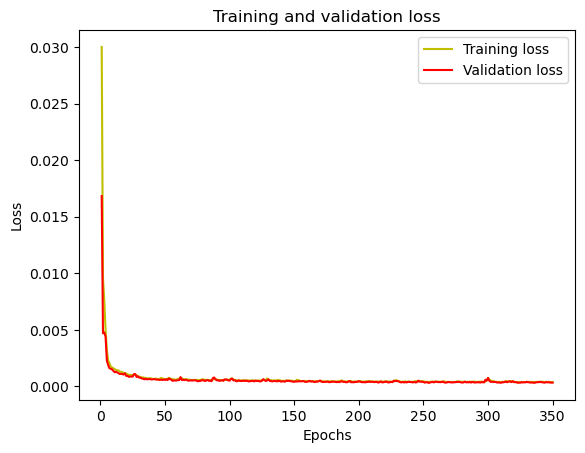

In [11]:
num_epochs = 350
# Plot training and validation loss
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'y', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


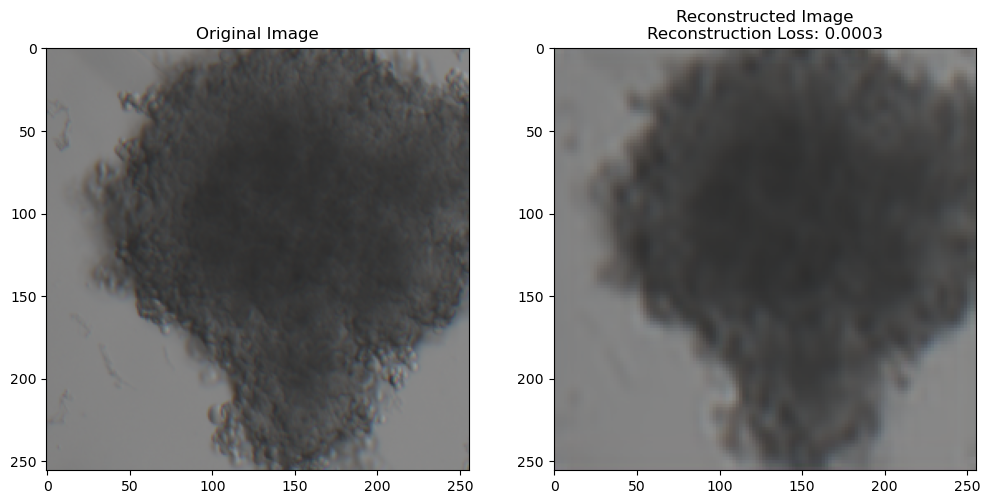

In [12]:
# Testing on a batch of images
data_batch = next(iter(train_loader))
images = data_batch
modi.eval()
with torch.no_grad():
    outputs = modi(images)

# Randomly select an image from the batch
image_number = random.randint(0, outputs.shape[0] - 1)

# Calculate the reconstruction loss for the selected image
single_image_loss = criterion(outputs[image_number].unsqueeze(0), images[image_number].unsqueeze(0)).item()

# Display original and reconstructed images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(121)
plt.title(f'Original Image')
plt.imshow(np.transpose(images[image_number].numpy(), (1, 2, 0)))

# Reconstructed image
plt.subplot(122)
plt.title(f'Reconstructed Image\nReconstruction Loss: {single_image_loss:.4f}')
plt.imshow(np.transpose(outputs[image_number].numpy(), (1, 2, 0)))

plt.show()


In [13]:
# Save the model parameters after training
torch.save(modi.state_dict(), 'modi.pth')


In [13]:
class Autoencod_tuning(nn.Module):
    def __init__(self):
        super(Autoencod_tuning, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding='same'),  # Input: (3, 96, 96) Output: (64, 96, 96)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),        # Output: (64, 48, 48)
            
            nn.Conv2d(16, 32, kernel_size=3, padding='same'), # Output: (32, 48, 48)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),        # Output: (32, 24, 24)
            
            nn.Conv2d(32, 64, kernel_size=3, padding='same'), # Output: (16, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0)         # Output: (16, 12, 12)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding='same'), # Output: (16, 12, 12)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (16, 24, 24)
            
            nn.Conv2d(32,16, kernel_size=3, padding='same'), # Output: (32, 24, 24)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (32, 48, 48)
            
            nn.Conv2d(16, 8, kernel_size=3, padding='same'), # Output: (64, 48, 48)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (64, 96, 96)
            
            nn.Conv2d(8, 3, kernel_size=3, padding='same'),  # Output: (3, 96, 96)
            nn.Sigmoid()
        )
        
    def forward(self, x):
        #print("Input:", x.shape)
        
        # Encoder
        for layer in self.encoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        # Decoder
        for layer in self.decoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        return x


In [14]:
mos = Autoencod_tuning()
criterion = nn.MSELoss()
optimizer = optim.Adam(mos.parameters(), lr=0.001)

In [15]:
def train_and_validate(mo, train_loader, val_loader, optimizer, criterion, num_epochs=1):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        
        # Training phase
        mos.train()
        train_loss = 0
        for images in train_loader:
            optimizer.zero_grad()
            outputs = mos(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        mos.eval()
        val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                outputs = mos(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        end_time = time.time()  # End time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch duration

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    return train_losses, val_losses


train_losses, val_losses = train_and_validate(mos, train_loader, val_loader, optimizer, criterion, num_epochs=1)


Epoch [1/1], Train Loss: 0.0394, Validation Loss: 0.0280, Time: 10.08 seconds


In [16]:
train_losses, val_losses = train_and_validate(mos, train_loader, val_loader, optimizer, criterion, num_epochs=100)
#256 

Epoch [1/100], Train Loss: 0.0203, Validation Loss: 0.0098, Time: 10.08 seconds
Epoch [2/100], Train Loss: 0.0077, Validation Loss: 0.0039, Time: 10.12 seconds
Epoch [3/100], Train Loss: 0.0042, Validation Loss: 0.0021, Time: 10.07 seconds
Epoch [4/100], Train Loss: 0.0023, Validation Loss: 0.0033, Time: 10.07 seconds
Epoch [5/100], Train Loss: 0.0025, Validation Loss: 0.0018, Time: 10.11 seconds
Epoch [6/100], Train Loss: 0.0021, Validation Loss: 0.0017, Time: 10.11 seconds
Epoch [7/100], Train Loss: 0.0019, Validation Loss: 0.0017, Time: 10.14 seconds
Epoch [8/100], Train Loss: 0.0015, Validation Loss: 0.0014, Time: 10.11 seconds
Epoch [9/100], Train Loss: 0.0015, Validation Loss: 0.0013, Time: 10.09 seconds
Epoch [10/100], Train Loss: 0.0014, Validation Loss: 0.0014, Time: 10.04 seconds
Epoch [11/100], Train Loss: 0.0014, Validation Loss: 0.0012, Time: 10.09 seconds
Epoch [12/100], Train Loss: 0.0013, Validation Loss: 0.0013, Time: 10.05 seconds
Epoch [13/100], Train Loss: 0.0013, V

In [17]:
train_losses, val_losses = train_and_validate(mos, train_loader, val_loader, optimizer, criterion, num_epochs=100)
#256 

Epoch [1/100], Train Loss: 0.0006, Validation Loss: 0.0006, Time: 18.72 seconds
Epoch [2/100], Train Loss: 0.0006, Validation Loss: 0.0005, Time: 18.66 seconds
Epoch [3/100], Train Loss: 0.0005, Validation Loss: 0.0006, Time: 18.81 seconds
Epoch [4/100], Train Loss: 0.0006, Validation Loss: 0.0005, Time: 18.96 seconds
Epoch [5/100], Train Loss: 0.0006, Validation Loss: 0.0006, Time: 18.73 seconds
Epoch [6/100], Train Loss: 0.0006, Validation Loss: 0.0005, Time: 11.82 seconds
Epoch [7/100], Train Loss: 0.0006, Validation Loss: 0.0006, Time: 10.34 seconds
Epoch [8/100], Train Loss: 0.0005, Validation Loss: 0.0006, Time: 10.16 seconds
Epoch [9/100], Train Loss: 0.0005, Validation Loss: 0.0006, Time: 10.41 seconds
Epoch [10/100], Train Loss: 0.0005, Validation Loss: 0.0005, Time: 10.25 seconds
Epoch [11/100], Train Loss: 0.0005, Validation Loss: 0.0005, Time: 10.31 seconds
Epoch [12/100], Train Loss: 0.0006, Validation Loss: 0.0005, Time: 10.14 seconds
Epoch [13/100], Train Loss: 0.0005, V

In [18]:
train_losses, val_losses = train_and_validate(mos, train_loader, val_loader, optimizer, criterion, num_epochs=100)
#256 

Epoch [1/100], Train Loss: 0.0005, Validation Loss: 0.0005, Time: 9.86 seconds
Epoch [2/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 9.86 seconds
Epoch [3/100], Train Loss: 0.0005, Validation Loss: 0.0005, Time: 15.11 seconds
Epoch [4/100], Train Loss: 0.0005, Validation Loss: 0.0005, Time: 18.33 seconds
Epoch [5/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 18.77 seconds
Epoch [6/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 18.82 seconds
Epoch [7/100], Train Loss: 0.0005, Validation Loss: 0.0004, Time: 18.70 seconds
Epoch [8/100], Train Loss: 0.0005, Validation Loss: 0.0004, Time: 18.50 seconds
Epoch [9/100], Train Loss: 0.0005, Validation Loss: 0.0004, Time: 18.35 seconds
Epoch [10/100], Train Loss: 0.0005, Validation Loss: 0.0005, Time: 18.56 seconds
Epoch [11/100], Train Loss: 0.0005, Validation Loss: 0.0004, Time: 18.00 seconds
Epoch [12/100], Train Loss: 0.0005, Validation Loss: 0.0005, Time: 18.10 seconds
Epoch [13/100], Train Loss: 0.0004, Val

In [22]:
train_losses, val_losses = train_and_validate(mos, train_loader, val_loader, optimizer, criterion, num_epochs=100)
#256 

Epoch [1/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 9.95 seconds
Epoch [2/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 10.50 seconds
Epoch [3/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 10.55 seconds
Epoch [4/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 10.61 seconds
Epoch [5/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 10.56 seconds
Epoch [6/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 10.59 seconds
Epoch [7/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 10.56 seconds
Epoch [8/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 10.56 seconds
Epoch [9/100], Train Loss: 0.0004, Validation Loss: 0.0005, Time: 13.73 seconds
Epoch [10/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 20.01 seconds
Epoch [11/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 20.63 seconds
Epoch [12/100], Train Loss: 0.0004, Validation Loss: 0.0004, Time: 20.53 seconds
Epoch [13/100], Train Loss: 0.0004, Va

In [24]:
# Save the model parameters after training
torch.save(mos.state_dict(), 'mos.pth')


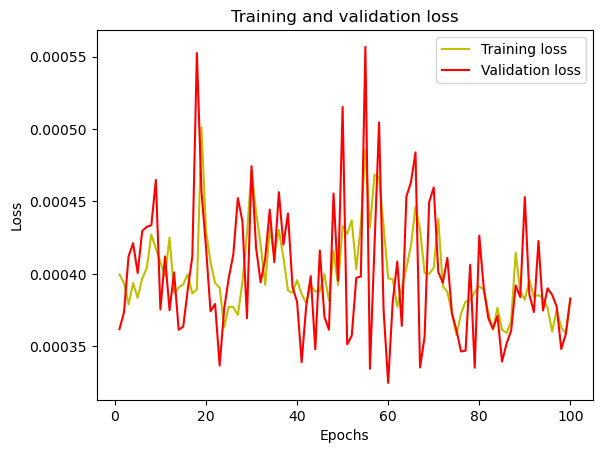

In [25]:
num_epochs = 100
# Plot training and validation loss
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'y', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


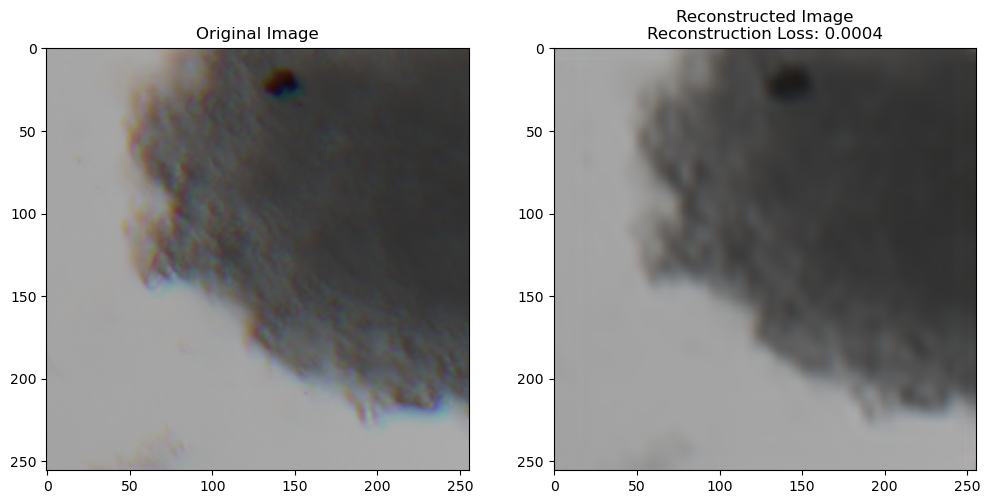

In [26]:
# Testing on a batch of images
data_batch = next(iter(train_loader))
images = data_batch
mos.eval()
with torch.no_grad():
    outputs = mos(images)

# Randomly select an image from the batch
image_number = random.randint(0, outputs.shape[0] - 1)

# Calculate the reconstruction loss for the selected image
single_image_loss = criterion(outputs[image_number].unsqueeze(0), images[image_number].unsqueeze(0)).item()

# Display original and reconstructed images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(121)
plt.title(f'Original Image')
plt.imshow(np.transpose(images[image_number].numpy(), (1, 2, 0)))

# Reconstructed image
plt.subplot(122)
plt.title(f'Reconstructed Image\nReconstruction Loss: {single_image_loss:.4f}')
plt.imshow(np.transpose(outputs[image_number].numpy(), (1, 2, 0)))

plt.show()


In [4]:
class Autoforsmall(nn.Module):
    def __init__(self):
        super(Autoforsmall, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Down to (16, 128, 128)

            nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Down to (32, 64, 64)

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Down to (64, 32, 32)

            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Down to (128, 16, 16)

            nn.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Down to (256, 8, 8)

            nn.Conv2d(256, 512, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)   # Down to (512, 4, 4)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # Up to (256, 8, 8)

            nn.Conv2d(256, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # Up to (128, 16, 16)

            nn.Conv2d(128, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # Up to (64, 32, 32)

            nn.Conv2d(64, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # Up to (32, 64, 64)

            nn.Conv2d(32, 16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), 

            nn.Conv2d(16,8,kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), # Up to (16, 128, 128)

            nn.Conv2d(8,3, kernel_size=3, padding='same'),
            nn.Upsample(scale_factor=1.5, mode='nearest'), 
            nn.Sigmoid()  # Final output (3, 256, 256)
            )
        
    def forward(self, x):
        #print("Input:", x.shape)
        
        # Encoder
        for layer in self.encoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        # Decoder
        for layer in self.decoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        return x


In [5]:
mo = Autoforsmall()
criterion = nn.MSELoss()
optimizer = optim.Adam(mo.parameters(), lr=0.001)

In [6]:
def train_and_validate(mo, train_loader, val_loader, optimizer, criterion, num_epochs=1):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        
        # Training phase
        mo.train()
        train_loss = 0
        for images in train_loader:
            optimizer.zero_grad()
            outputs = mo(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        mo.eval()
        val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                outputs = mo(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        end_time = time.time()  # End time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch duration

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    return train_losses, val_losses


train_losses, val_losses = train_and_validate(mo, train_loader, val_loader, optimizer, criterion, num_epochs=100)


Epoch [1/100], Train Loss: 0.0397, Validation Loss: 0.0390, Time: 9.18 seconds
Epoch [2/100], Train Loss: 0.0368, Validation Loss: 0.0375, Time: 9.21 seconds
Epoch [3/100], Train Loss: 0.0339, Validation Loss: 0.0320, Time: 9.17 seconds
Epoch [4/100], Train Loss: 0.0328, Validation Loss: 0.0330, Time: 9.26 seconds
Epoch [5/100], Train Loss: 0.0326, Validation Loss: 0.0331, Time: 9.24 seconds
Epoch [6/100], Train Loss: 0.0305, Validation Loss: 0.0304, Time: 9.14 seconds
Epoch [7/100], Train Loss: 0.0293, Validation Loss: 0.0277, Time: 9.25 seconds
Epoch [8/100], Train Loss: 0.0296, Validation Loss: 0.0292, Time: 9.21 seconds
Epoch [9/100], Train Loss: 0.0293, Validation Loss: 0.0301, Time: 9.18 seconds
Epoch [10/100], Train Loss: 0.0276, Validation Loss: 0.0264, Time: 9.14 seconds
Epoch [11/100], Train Loss: 0.0276, Validation Loss: 0.0282, Time: 9.28 seconds
Epoch [12/100], Train Loss: 0.0272, Validation Loss: 0.0268, Time: 9.29 seconds
Epoch [13/100], Train Loss: 0.0264, Validation Lo

In [7]:
train_losses, val_losses = train_and_validate(mo, train_loader, val_loader, optimizer, criterion, num_epochs=50)

Epoch [1/50], Train Loss: 0.0037, Validation Loss: 0.0051, Time: 9.26 seconds
Epoch [2/50], Train Loss: 0.0043, Validation Loss: 0.0052, Time: 9.23 seconds
Epoch [3/50], Train Loss: 0.0042, Validation Loss: 0.0035, Time: 9.27 seconds
Epoch [4/50], Train Loss: 0.0036, Validation Loss: 0.0047, Time: 9.32 seconds
Epoch [5/50], Train Loss: 0.0036, Validation Loss: 0.0038, Time: 9.32 seconds
Epoch [6/50], Train Loss: 0.0036, Validation Loss: 0.0036, Time: 9.22 seconds
Epoch [7/50], Train Loss: 0.0035, Validation Loss: 0.0040, Time: 9.34 seconds
Epoch [8/50], Train Loss: 0.0035, Validation Loss: 0.0043, Time: 9.19 seconds
Epoch [9/50], Train Loss: 0.0034, Validation Loss: 0.0040, Time: 9.44 seconds
Epoch [10/50], Train Loss: 0.0031, Validation Loss: 0.0029, Time: 9.32 seconds
Epoch [11/50], Train Loss: 0.0031, Validation Loss: 0.0034, Time: 9.24 seconds
Epoch [12/50], Train Loss: 0.0033, Validation Loss: 0.0033, Time: 9.22 seconds
Epoch [13/50], Train Loss: 0.0036, Validation Loss: 0.0040, T

In [8]:
train_losses, val_losses = train_and_validate(mo, train_loader, val_loader, optimizer, criterion, num_epochs=150)

Epoch [1/150], Train Loss: 0.0028, Validation Loss: 0.0033, Time: 9.30 seconds
Epoch [2/150], Train Loss: 0.0028, Validation Loss: 0.0032, Time: 9.27 seconds
Epoch [3/150], Train Loss: 0.0027, Validation Loss: 0.0029, Time: 9.34 seconds
Epoch [4/150], Train Loss: 0.0025, Validation Loss: 0.0029, Time: 9.26 seconds
Epoch [5/150], Train Loss: 0.0026, Validation Loss: 0.0033, Time: 9.29 seconds
Epoch [6/150], Train Loss: 0.0026, Validation Loss: 0.0032, Time: 9.37 seconds
Epoch [7/150], Train Loss: 0.0026, Validation Loss: 0.0024, Time: 9.26 seconds
Epoch [8/150], Train Loss: 0.0027, Validation Loss: 0.0029, Time: 9.35 seconds
Epoch [9/150], Train Loss: 0.0030, Validation Loss: 0.0033, Time: 9.16 seconds
Epoch [10/150], Train Loss: 0.0031, Validation Loss: 0.0033, Time: 9.27 seconds
Epoch [11/150], Train Loss: 0.0033, Validation Loss: 0.0036, Time: 9.26 seconds
Epoch [12/150], Train Loss: 0.0032, Validation Loss: 0.0036, Time: 9.37 seconds
Epoch [13/150], Train Loss: 0.0032, Validation Lo

In [9]:
train_losses, val_losses = train_and_validate(mo, train_loader, val_loader, optimizer, criterion, num_epochs=200)

Epoch [1/200], Train Loss: 0.0022, Validation Loss: 0.0022, Time: 9.18 seconds
Epoch [2/200], Train Loss: 0.0022, Validation Loss: 0.0023, Time: 9.34 seconds
Epoch [3/200], Train Loss: 0.0020, Validation Loss: 0.0025, Time: 9.24 seconds
Epoch [4/200], Train Loss: 0.0021, Validation Loss: 0.0023, Time: 9.29 seconds
Epoch [5/200], Train Loss: 0.0021, Validation Loss: 0.0026, Time: 9.12 seconds
Epoch [6/200], Train Loss: 0.0021, Validation Loss: 0.0020, Time: 9.19 seconds
Epoch [7/200], Train Loss: 0.0020, Validation Loss: 0.0026, Time: 9.16 seconds
Epoch [8/200], Train Loss: 0.0021, Validation Loss: 0.0022, Time: 9.18 seconds
Epoch [9/200], Train Loss: 0.0021, Validation Loss: 0.0023, Time: 9.25 seconds
Epoch [10/200], Train Loss: 0.0021, Validation Loss: 0.0026, Time: 9.18 seconds
Epoch [11/200], Train Loss: 0.0020, Validation Loss: 0.0021, Time: 9.23 seconds
Epoch [12/200], Train Loss: 0.0021, Validation Loss: 0.0025, Time: 9.26 seconds
Epoch [13/200], Train Loss: 0.0021, Validation Lo

In [10]:
train_losses, val_losses = train_and_validate(mo, train_loader, val_loader, optimizer, criterion, num_epochs=200)

Epoch [1/200], Train Loss: 0.0018, Validation Loss: 0.0017, Time: 9.22 seconds
Epoch [2/200], Train Loss: 0.0017, Validation Loss: 0.0018, Time: 9.29 seconds
Epoch [3/200], Train Loss: 0.0017, Validation Loss: 0.0019, Time: 9.35 seconds
Epoch [4/200], Train Loss: 0.0017, Validation Loss: 0.0016, Time: 9.26 seconds
Epoch [5/200], Train Loss: 0.0016, Validation Loss: 0.0020, Time: 9.27 seconds
Epoch [6/200], Train Loss: 0.0017, Validation Loss: 0.0018, Time: 9.19 seconds
Epoch [7/200], Train Loss: 0.0017, Validation Loss: 0.0017, Time: 9.31 seconds
Epoch [8/200], Train Loss: 0.0017, Validation Loss: 0.0016, Time: 10.25 seconds
Epoch [9/200], Train Loss: 0.0017, Validation Loss: 0.0017, Time: 17.12 seconds
Epoch [10/200], Train Loss: 0.0018, Validation Loss: 0.0017, Time: 17.00 seconds
Epoch [11/200], Train Loss: 0.0017, Validation Loss: 0.0019, Time: 16.96 seconds
Epoch [12/200], Train Loss: 0.0017, Validation Loss: 0.0017, Time: 16.77 seconds
Epoch [13/200], Train Loss: 0.0017, Validati

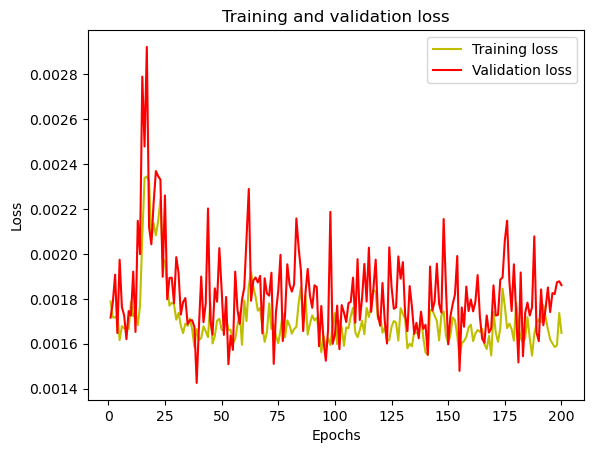

In [12]:
num_epochs = 200
# Plot training and validation loss
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'y', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


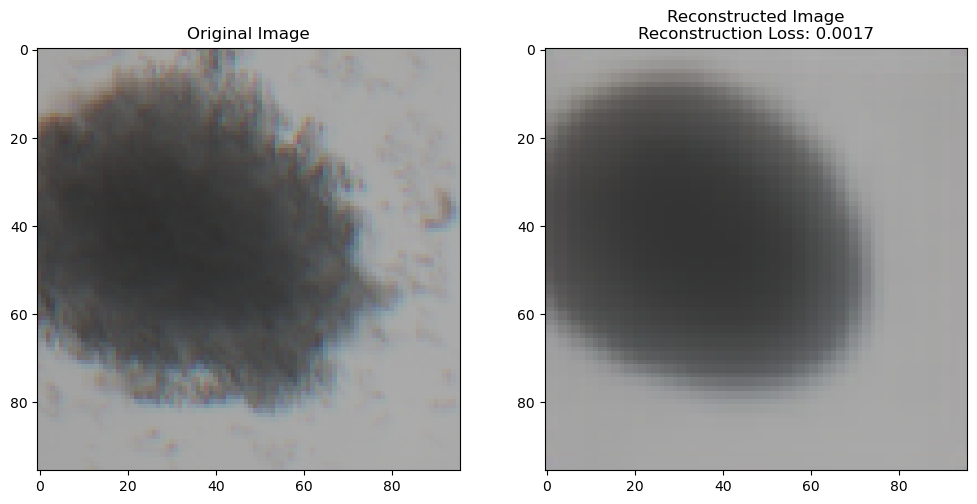

In [16]:
# Testing on a batch of images
data_batch = next(iter(train_loader))
images = data_batch
mo.eval()
with torch.no_grad():
    outputs = mo(images)

# Randomly select an image from the batch
image_number = random.randint(0, outputs.shape[0] - 1)

# Calculate the reconstruction loss for the selected image
single_image_loss = criterion(outputs[image_number].unsqueeze(0), images[image_number].unsqueeze(0)).item()

# Display original and reconstructed images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(121)
plt.title(f'Original Image')
plt.imshow(np.transpose(images[image_number].numpy(), (1, 2, 0)))

# Reconstructed image
plt.subplot(122)
plt.title(f'Reconstructed Image\nReconstruction Loss: {single_image_loss:.4f}')
plt.imshow(np.transpose(outputs[image_number].numpy(), (1, 2, 0)))

plt.show()


In [17]:
class Auto(nn.Module):
    def __init__(self):
        super(Auto, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Down to (16, 128, 128)

            nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Down to (32, 64, 64)

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Down to (64, 32, 32)

            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Down to (128, 16, 16)

            nn.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Down to (256, 8, 8)

            nn.Conv2d(256, 512, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)   # Down to (512, 4, 4)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # Up to (256, 8, 8)

            nn.Conv2d(256, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # Up to (128, 16, 16)

            nn.Conv2d(128, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # Up to (64, 32, 32)

            nn.Conv2d(64, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # Up to (32, 64, 64)

            nn.Conv2d(32, 16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # Up to (16, 128, 128)

            nn.Conv2d(16, 3, kernel_size=3, padding='same'),
            nn.Upsample(scale_factor=2, mode='nearest'), 
            nn.Sigmoid()  # Final output (3, 256, 256)
            )
        
    def forward(self, x):
        print("Input:", x.shape)
        
        # Encoder
        for layer in self.encoder:
            x = layer(x)
            print(f"After {layer}: {x.shape}")
        
        # Decoder
        for layer in self.decoder:
            x = layer(x)
            print(f"After {layer}: {x.shape}")
        
        return x


In [18]:
mo = Auto()
criterion = nn.MSELoss()
optimizer = optim.Adam(mo.parameters(), lr=0.001)

In [19]:
def train_and_validate(mo, train_loader, val_loader, optimizer, criterion, num_epochs=1):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        
        # Training phase
        mo.train()
        train_loss = 0
        for images in train_loader:
            optimizer.zero_grad()
            outputs = mo(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        mo.eval()
        val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                outputs = mo(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        end_time = time.time()  # End time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch duration

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    return train_losses, val_losses


train_losses, val_losses = train_and_validate(mo, train_loader, val_loader, optimizer, criterion, num_epochs=1)


Input: torch.Size([16, 3, 96, 96])
After Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same): torch.Size([16, 16, 96, 96])
After ReLU(): torch.Size([16, 16, 96, 96])
After MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): torch.Size([16, 16, 48, 48])
After Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same): torch.Size([16, 32, 48, 48])
After ReLU(): torch.Size([16, 32, 48, 48])
After MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): torch.Size([16, 32, 24, 24])
After Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same): torch.Size([16, 64, 24, 24])
After ReLU(): torch.Size([16, 64, 24, 24])
After MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): torch.Size([16, 64, 12, 12])
After Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same): torch.Size([16, 128, 12, 12])
After ReLU(): torch.Size([16, 128, 12, 12])
After MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [4]:
class Cae(nn.Module):
    def __init__(self):
        super(Cae, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input: (3, 96, 96) Output: (32, 96, 96)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),        # Output: (32, 48, 48)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Output: (64, 48, 48)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),        # Output: (64, 24, 24)
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Output: (128, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),

            nn.Conv2d(128,256, kernel_size=3, padding=1), # Output: (128, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),          # Output: (128, 12, 12)

            nn.Conv2d(256,512, kernel_size=3, padding=1), # Output: (128, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0) 
        )

        # Decoder
        self.decoder = nn.Sequential(

            nn.Conv2d(512, 256, kernel_size=3, padding=1), # Output: (64, 12, 12)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # Output: (64, 24, 24)


            nn.Conv2d(256,128, kernel_size=3, padding=1), # Output: (64, 12, 12)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # Output: (64, 24, 24)
            
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # Output: (32, 24, 24)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # Output: (32, 48, 48)
            
            nn.Conv2d(64, 32, kernel_size=3, padding=1),   # Output: (3, 48, 48)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # Output: (3, 96, 96)
            
            nn.Conv2d(32, 3, kernel_size=3, padding=1),    # Final output: (3, 96, 96)
            nn.Upsample(scale_factor=2, mode='nearest'),  # Output: (3, 96, 96)
            nn.Sigmoid()
        )
        
    def forward(self, x):
        print("Input:", x.shape)
        
        # Encoder
        for layer in self.encoder:
            x = layer(x)
            print(f"After {layer}: {x.shape}")
        
        # Decoder
        for layer in self.decoder:
            x = layer(x)
            print(f"After {layer}: {x.shape}")
        
        return x


In [5]:
mosel = Cae()
criterion = nn.MSELoss()
optimizer = optim.Adam(mosel.parameters(), lr=0.001)

In [6]:
def train_and_validate(mo, train_loader, val_loader, optimizer, criterion, num_epochs=1):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        
        # Training phase
        mosel.train()
        train_loss = 0
        for images in train_loader:
            optimizer.zero_grad()
            outputs = mosel(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        mosel.eval()
        val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                outputs = mosel(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        end_time = time.time()  # End time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch duration

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    return train_losses, val_losses

In [7]:
train_losses, val_losses = train_and_validate(mosel, train_loader, val_loader, optimizer, criterion, num_epochs=1)

Epoch [1/1], Train Loss: 0.0371, Validation Loss: 0.0262, Time: 11.81 seconds


In [8]:
train_losses, val_losses = train_and_validate(mosel, train_loader, val_loader, optimizer, criterion, num_epochs=100)

Epoch [1/100], Train Loss: 0.0187, Validation Loss: 0.0113, Time: 11.84 seconds
Epoch [2/100], Train Loss: 0.0132, Validation Loss: 0.0090, Time: 11.78 seconds
Epoch [3/100], Train Loss: 0.0082, Validation Loss: 0.0075, Time: 11.69 seconds
Epoch [4/100], Train Loss: 0.0059, Validation Loss: 0.0050, Time: 11.79 seconds
Epoch [5/100], Train Loss: 0.0054, Validation Loss: 0.0037, Time: 11.74 seconds
Epoch [6/100], Train Loss: 0.0042, Validation Loss: 0.0031, Time: 11.77 seconds
Epoch [7/100], Train Loss: 0.0037, Validation Loss: 0.0031, Time: 11.78 seconds
Epoch [8/100], Train Loss: 0.0032, Validation Loss: 0.0025, Time: 11.71 seconds
Epoch [9/100], Train Loss: 0.0029, Validation Loss: 0.0026, Time: 11.72 seconds
Epoch [10/100], Train Loss: 0.0026, Validation Loss: 0.0022, Time: 11.66 seconds
Epoch [11/100], Train Loss: 0.0023, Validation Loss: 0.0020, Time: 11.81 seconds
Epoch [12/100], Train Loss: 0.0023, Validation Loss: 0.0018, Time: 11.75 seconds
Epoch [13/100], Train Loss: 0.0020, V

In [9]:
train_losses, val_losses = train_and_validate(mosel, train_loader, val_loader, optimizer, criterion, num_epochs=200)

Epoch [1/200], Train Loss: 0.0008, Validation Loss: 0.0007, Time: 11.83 seconds
Epoch [2/200], Train Loss: 0.0010, Validation Loss: 0.0008, Time: 11.86 seconds
Epoch [3/200], Train Loss: 0.0011, Validation Loss: 0.0009, Time: 11.74 seconds
Epoch [4/200], Train Loss: 0.0012, Validation Loss: 0.0007, Time: 11.88 seconds
Epoch [5/200], Train Loss: 0.0009, Validation Loss: 0.0008, Time: 11.89 seconds
Epoch [6/200], Train Loss: 0.0009, Validation Loss: 0.0008, Time: 11.83 seconds
Epoch [7/200], Train Loss: 0.0009, Validation Loss: 0.0008, Time: 11.82 seconds
Epoch [8/200], Train Loss: 0.0009, Validation Loss: 0.0007, Time: 11.88 seconds
Epoch [9/200], Train Loss: 0.0008, Validation Loss: 0.0007, Time: 11.90 seconds
Epoch [10/200], Train Loss: 0.0009, Validation Loss: 0.0007, Time: 11.81 seconds
Epoch [11/200], Train Loss: 0.0008, Validation Loss: 0.0007, Time: 11.84 seconds
Epoch [12/200], Train Loss: 0.0008, Validation Loss: 0.0006, Time: 11.78 seconds
Epoch [13/200], Train Loss: 0.0008, V

In [ ]:
#look the bottleneck dim, if it didn't go to 0.0005 then make it closer to the initial one like reduce to 256 then to 128

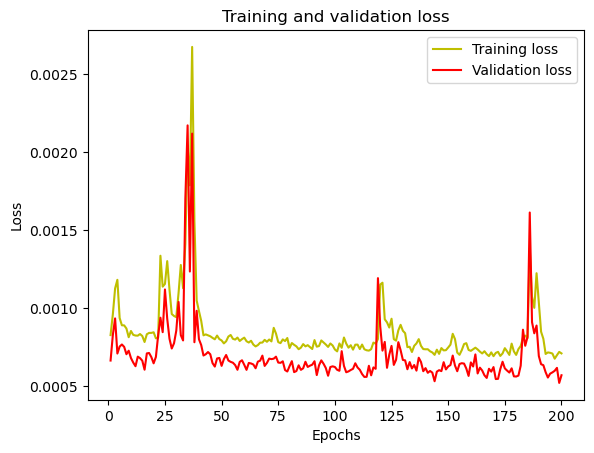

In [10]:
num_epochs = 200
# Plot training and validation loss
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'y', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


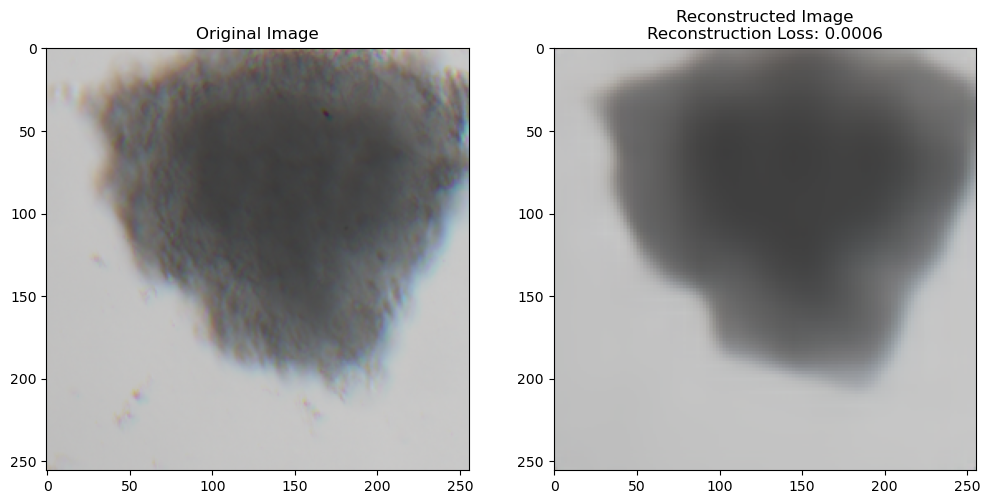

In [12]:
# Testing on a batch of images
data_batch = next(iter(train_loader))
images = data_batch
mosel.eval()
with torch.no_grad():
    outputs = mosel(images)

# Randomly select an image from the batch
image_number = random.randint(0, outputs.shape[0] - 1)

# Calculate the reconstruction loss for the selected image
single_image_loss = criterion(outputs[image_number].unsqueeze(0), images[image_number].unsqueeze(0)).item()

# Display original and reconstructed images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(121)
plt.title(f'Original Image')
plt.imshow(np.transpose(images[image_number].numpy(), (1, 2, 0)))

# Reconstructed image
plt.subplot(122)
plt.title(f'Reconstructed Image\nReconstruction Loss: {single_image_loss:.4f}')
plt.imshow(np.transpose(outputs[image_number].numpy(), (1, 2, 0)))

plt.show()


In [138]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0),  # Removed padding here to get 96 *96 at output

            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0),  # Removed padding here to get 96 *96 at output

            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0)  # Removed padding here to get 96 *96 at output
        )
        
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1), # Output: (16, 12, 12)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (16, 24, 24)
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # Output: (32, 24, 24)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (32, 48, 48)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Output: (64, 48, 48)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (64, 96, 96)
            
            nn.Conv2d(64, 3, kernel_size=3, padding=1),  # Output: (3, 96, 96)
            
            nn.Sigmoid()
        )
        
    def forward(self, x):
        #print("Input:", x.shape)
        
        # Encoder
        for layer in self.encoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        # Decoder
        for layer in self.decoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        return x


In [36]:
class Autoencodering(nn.Module):
    def __init__(self):
        super(Autoencodering, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Input: (3, 96, 96) Output: (64, 96, 96)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0),        # Output: (64, 48, 48)
            
            nn.Conv2d(64, 32, kernel_size=3, padding=1), # Output: (32, 48, 48)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0),        # Output: (32, 24, 24)
            
            nn.Conv2d(32, 16, kernel_size=3, padding=1), # Output: (16, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0)         # Output: (16, 12, 12)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1), # Output: (16, 12, 12)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (16, 24, 24)
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # Output: (32, 24, 24)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (32, 48, 48)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Output: (64, 48, 48)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (64, 96, 96)
            
            nn.Conv2d(64, 3, kernel_size=3, padding=1),  # Output: (3, 96, 96)
            nn.Sigmoid()
        )
        
    def forward(self, x):
        #print("Input:", x.shape)
        
        # Encoder
        for layer in self.encoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        # Decoder
        for layer in self.decoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        return x


In [26]:
class Autoencod(nn.Module):
    def __init__(self):
        super(Autoencod, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding='same'),  # Input: (3, 96, 96) Output: (64, 96, 96)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),        # Output: (64, 48, 48)
            
            nn.Conv2d(64, 32, kernel_size=3, padding='same'), # Output: (32, 48, 48)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),        # Output: (32, 24, 24)
            
            nn.Conv2d(32, 16, kernel_size=3, padding='same'), # Output: (16, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0)         # Output: (16, 12, 12)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding='same'), # Output: (16, 12, 12)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (16, 24, 24)
            
            nn.Conv2d(16, 32, kernel_size=3, padding='same'), # Output: (32, 24, 24)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (32, 48, 48)
            
            nn.Conv2d(32, 64, kernel_size=3, padding='same'), # Output: (64, 48, 48)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (64, 96, 96)
            
            nn.Conv2d(64, 3, kernel_size=3, padding='same'),  # Output: (3, 96, 96)
            nn.Sigmoid()
        )
        
    def forward(self, x):
        #print("Input:", x.shape)
        
        # Encoder
        for layer in self.encoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        # Decoder
        for layer in self.decoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        return x


In [4]:
class Auto(nn.Module):
    def __init__(self):
        super(Auto, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Down to (16, 128, 128)

            nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Down to (32, 64, 64)

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Down to (64, 32, 32)

            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Down to (128, 16, 16)

            nn.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Down to (256, 8, 8)

            nn.Conv2d(256, 512, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)   # Down to (512, 4, 4)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # Up to (256, 8, 8)

            nn.Conv2d(256, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # Up to (128, 16, 16)

            nn.Conv2d(128, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # Up to (64, 32, 32)

            nn.Conv2d(64, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # Up to (32, 64, 64)

            nn.Conv2d(32, 16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # Up to (16, 128, 128)

            nn.Conv2d(16, 3, kernel_size=3, padding='same'),
            nn.Upsample(scale_factor=2, mode='nearest'), 
            nn.Sigmoid()  # Final output (3, 256, 256)
            )
        
    def forward(self, x):
        #print("Input:", x.shape)
        
        # Encoder
        for layer in self.encoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        # Decoder
        for layer in self.decoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        return x


In [5]:
mo = Auto()
criterion = nn.MSELoss()
optimizer = optim.Adam(mo.parameters(), lr=0.001)

In [7]:
def train_and_validate(mo, train_loader, val_loader, optimizer, criterion, num_epochs=1):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        
        # Training phase
        mo.train()
        train_loss = 0
        for images in train_loader:
            optimizer.zero_grad()
            outputs = mo(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        mo.eval()
        val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                outputs = mo(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        end_time = time.time()  # End time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch duration

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    return train_losses, val_losses


train_losses, val_losses = train_and_validate(mo, train_loader, val_loader, optimizer, criterion, num_epochs=100)


Epoch [1/100], Train Loss: 0.0396, Validation Loss: 0.0479, Time: 10.09 seconds
Epoch [2/100], Train Loss: 0.0388, Validation Loss: 0.0501, Time: 10.26 seconds
Epoch [3/100], Train Loss: 0.0347, Validation Loss: 0.0366, Time: 10.20 seconds
Epoch [4/100], Train Loss: 0.0312, Validation Loss: 0.0166, Time: 10.23 seconds
Epoch [5/100], Train Loss: 0.0162, Validation Loss: 0.0201, Time: 17.97 seconds
Epoch [6/100], Train Loss: 0.0123, Validation Loss: 0.0092, Time: 18.20 seconds
Epoch [7/100], Train Loss: 0.0078, Validation Loss: 0.0087, Time: 18.50 seconds
Epoch [8/100], Train Loss: 0.0072, Validation Loss: 0.0075, Time: 11.90 seconds
Epoch [9/100], Train Loss: 0.0062, Validation Loss: 0.0065, Time: 13.91 seconds
Epoch [10/100], Train Loss: 0.0055, Validation Loss: 0.0058, Time: 18.32 seconds
Epoch [11/100], Train Loss: 0.0050, Validation Loss: 0.0054, Time: 18.29 seconds
Epoch [12/100], Train Loss: 0.0046, Validation Loss: 0.0047, Time: 10.90 seconds
Epoch [13/100], Train Loss: 0.0039, V

In [11]:
train_losses, val_losses = train_and_validate(mo, train_loader, val_loader, optimizer, criterion, num_epochs=100)

Epoch [1/100], Train Loss: 0.0012, Validation Loss: 0.0015, Time: 10.24 seconds
Epoch [2/100], Train Loss: 0.0013, Validation Loss: 0.0015, Time: 10.39 seconds
Epoch [3/100], Train Loss: 0.0013, Validation Loss: 0.0015, Time: 10.31 seconds
Epoch [4/100], Train Loss: 0.0013, Validation Loss: 0.0014, Time: 10.32 seconds
Epoch [5/100], Train Loss: 0.0013, Validation Loss: 0.0016, Time: 10.37 seconds
Epoch [6/100], Train Loss: 0.0013, Validation Loss: 0.0013, Time: 11.47 seconds
Epoch [7/100], Train Loss: 0.0013, Validation Loss: 0.0020, Time: 18.46 seconds
Epoch [8/100], Train Loss: 0.0037, Validation Loss: 0.0045, Time: 18.45 seconds
Epoch [9/100], Train Loss: 0.0052, Validation Loss: 0.0063, Time: 18.54 seconds
Epoch [10/100], Train Loss: 0.0039, Validation Loss: 0.0021, Time: 18.72 seconds
Epoch [11/100], Train Loss: 0.0024, Validation Loss: 0.0024, Time: 18.62 seconds
Epoch [12/100], Train Loss: 0.0022, Validation Loss: 0.0022, Time: 18.52 seconds
Epoch [13/100], Train Loss: 0.0017, V

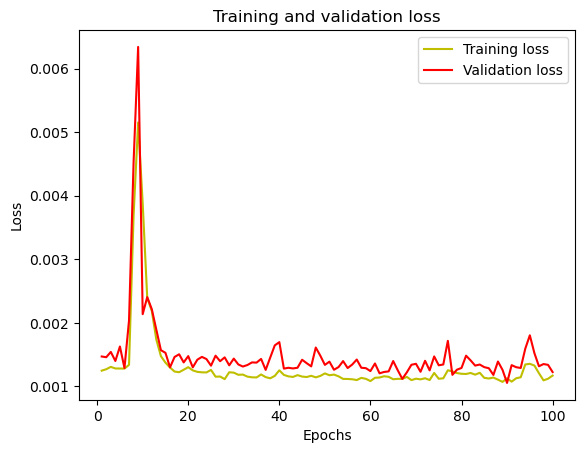

In [12]:
num_epochs = 100
# Plot training and validation loss
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'y', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


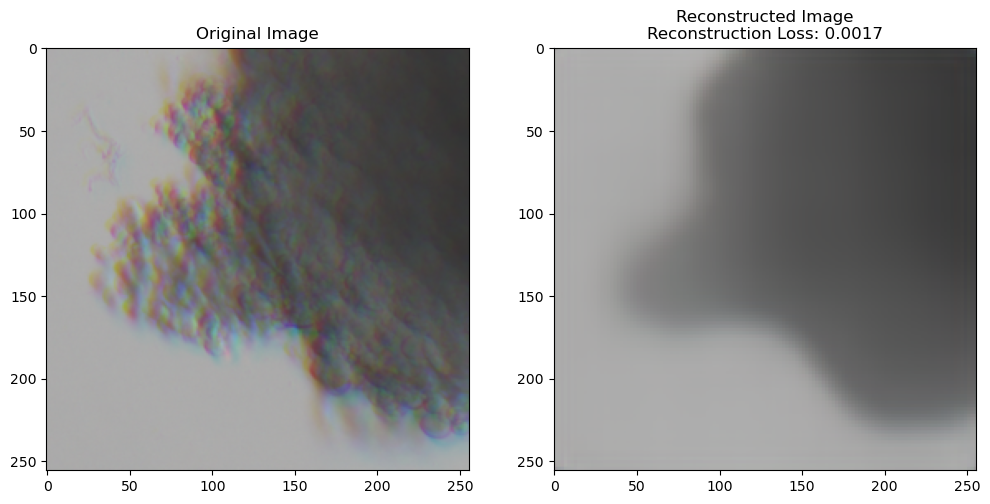

In [14]:
# Testing on a batch of images
data_batch = next(iter(train_loader))
images = data_batch
mo.eval()
with torch.no_grad():
    outputs = mo(images)

# Randomly select an image from the batch
image_number = random.randint(0, outputs.shape[0] - 1)

# Calculate the reconstruction loss for the selected image
single_image_loss = criterion(outputs[image_number].unsqueeze(0), images[image_number].unsqueeze(0)).item()

# Display original and reconstructed images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(121)
plt.title(f'Original Image')
plt.imshow(np.transpose(images[image_number].numpy(), (1, 2, 0)))

# Reconstructed image
plt.subplot(122)
plt.title(f'Reconstructed Image\nReconstruction Loss: {single_image_loss:.4f}')
plt.imshow(np.transpose(outputs[image_number].numpy(), (1, 2, 0)))

plt.show()


In [12]:


# Training the model
num_epochs = 1
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()  # Start time for the epoch
    
    mo.train()
    train_loss = 0
    for images in train_loader:
        optimizer.zero_grad()
        outputs = mo(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    mo.eval()
    val_loss = 0
    with torch.no_grad():
        for images in val_loader:
            outputs = mo(images)
            loss = criterion(outputs, images)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    end_time = time.time()  # End time for the epoch
    epoch_time = end_time - start_time  # Calculate epoch duration
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')


Input: torch.Size([16, 3, 256, 256])
After Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same): torch.Size([16, 16, 256, 256])
After ReLU(): torch.Size([16, 16, 256, 256])
After MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): torch.Size([16, 16, 128, 128])
After Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same): torch.Size([16, 32, 128, 128])
After ReLU(): torch.Size([16, 32, 128, 128])
After MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): torch.Size([16, 32, 64, 64])
After Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same): torch.Size([16, 64, 64, 64])
After ReLU(): torch.Size([16, 64, 64, 64])
After MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): torch.Size([16, 64, 32, 32])
After Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same): torch.Size([16, 128, 32, 32])
After ReLU(): torch.Size([16, 128, 32, 32])
After MaxPool2d(kernel_size=2, stride=2, paddi

In [35]:
mod = Autoencod()
criterion = nn.MSELoss()
optimizer = optim.Adam(mod.parameters(), lr=0.001)

In [27]:
# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

NameError: name 'Autoencoder' is not defined

In [28]:
modeling = Autoencodering()
criterion = nn.MSELoss()
optimizer = optim.Adam(modeling.parameters(), lr=0.001)

NameError: name 'Autoencodering' is not defined

In [29]:
mode = Autoencod()
criterion = nn.MSELoss()
optimizer = optim.Adam(mode.parameters(), lr=0.001)

In [36]:
# Training the model
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()  # Start time for the epoch
    
    mod.train()
    train_loss = 0
    for images in train_loader:
        optimizer.zero_grad()
        outputs = mod(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    mod.eval()
    val_loss = 0
    with torch.no_grad():
        for images in val_loader:
            outputs = mod(images)
            loss = criterion(outputs, images)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    end_time = time.time()  # End time for the epoch
    epoch_time = end_time - start_time  # Calculate epoch duration
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')


Epoch [1/100], Train Loss: 0.0377, Validation Loss: 0.0428, Time: 13.65 seconds
Epoch [2/100], Train Loss: 0.0220, Validation Loss: 0.0062, Time: 13.46 seconds
Epoch [3/100], Train Loss: 0.0109, Validation Loss: 0.0069, Time: 13.58 seconds
Epoch [4/100], Train Loss: 0.0071, Validation Loss: 0.0068, Time: 13.68 seconds
Epoch [5/100], Train Loss: 0.0047, Validation Loss: 0.0039, Time: 19.03 seconds
Epoch [6/100], Train Loss: 0.0031, Validation Loss: 0.0036, Time: 24.43 seconds
Epoch [7/100], Train Loss: 0.0026, Validation Loss: 0.0024, Time: 24.52 seconds
Epoch [8/100], Train Loss: 0.0019, Validation Loss: 0.0019, Time: 16.04 seconds
Epoch [9/100], Train Loss: 0.0014, Validation Loss: 0.0016, Time: 13.49 seconds
Epoch [10/100], Train Loss: 0.0013, Validation Loss: 0.0014, Time: 13.44 seconds
Epoch [11/100], Train Loss: 0.0012, Validation Loss: 0.0013, Time: 13.58 seconds
Epoch [12/100], Train Loss: 0.0011, Validation Loss: 0.0013, Time: 13.60 seconds
Epoch [13/100], Train Loss: 0.0010, V

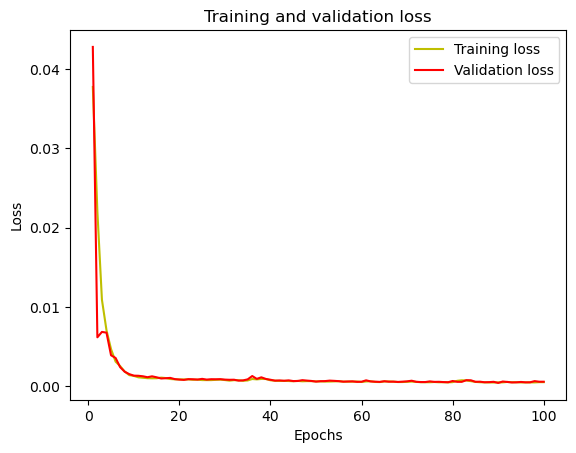

In [37]:
# Plot training and validation loss
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'y', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


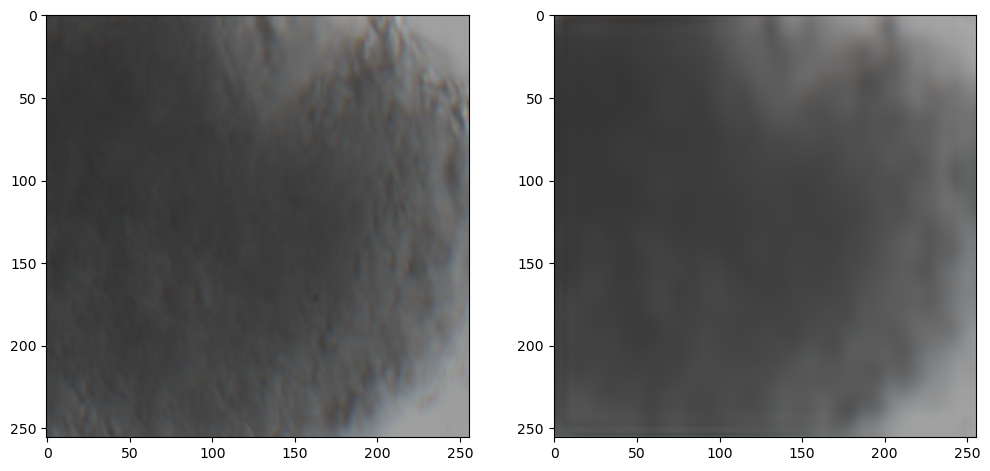

In [38]:
# Testing on a batch of images
data_batch = next(iter(train_loader))
images = data_batch
mod.eval()
with torch.no_grad():
    outputs = mod(images)

# Display original and reconstructed images
image_number = random.randint(0, outputs.shape[0] - 1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.transpose(images[image_number].numpy(), (1, 2, 0)))
plt.subplot(122)
plt.imshow(np.transpose(outputs[image_number].numpy(), (1, 2, 0)))
plt.show()

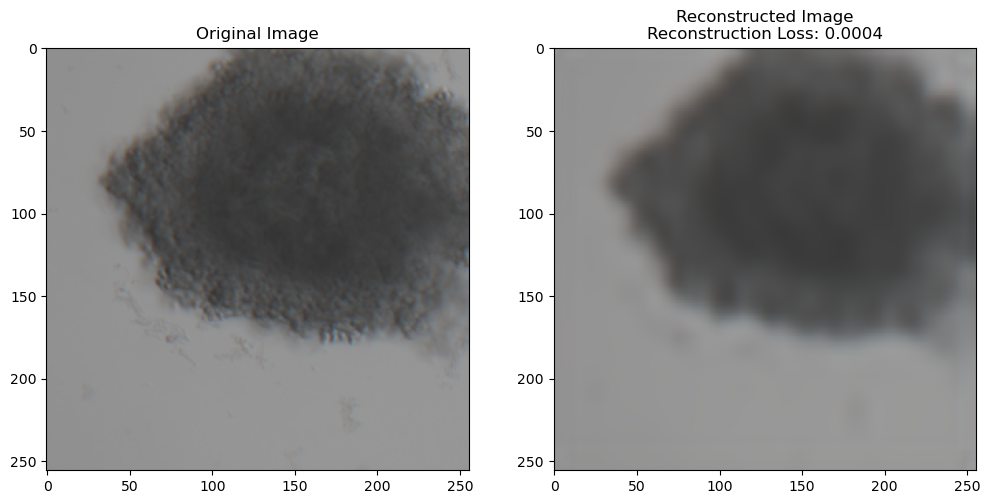

In [43]:
# Testing on a batch of images
data_batch = next(iter(train_loader))
images = data_batch
mod.eval()
with torch.no_grad():
    outputs = mod(images)

# Randomly select an image from the batch
image_number = random.randint(0, outputs.shape[0] - 1)

# Calculate the reconstruction loss for the selected image
single_image_loss = criterion(outputs[image_number].unsqueeze(0), images[image_number].unsqueeze(0)).item()

# Display original and reconstructed images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(121)
plt.title(f'Original Image')
plt.imshow(np.transpose(images[image_number].numpy(), (1, 2, 0)))

# Reconstructed image
plt.subplot(122)
plt.title(f'Reconstructed Image\nReconstruction Loss: {single_image_loss:.4f}')
plt.imshow(np.transpose(outputs[image_number].numpy(), (1, 2, 0)))

plt.show()


In [30]:
# Training the model
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()  # Start time for the epoch
    
    mode.train()
    train_loss = 0
    for images in train_loader:
        optimizer.zero_grad()
        outputs = mode(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    mode.eval()
    val_loss = 0
    with torch.no_grad():
        for images in val_loader:
            outputs = mode(images)
            loss = criterion(outputs, images)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    end_time = time.time()  # End time for the epoch
    epoch_time = end_time - start_time  # Calculate epoch duration
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')


Epoch [1/100], Train Loss: 0.0384, Validation Loss: 0.0445, Time: 13.97 seconds
Epoch [2/100], Train Loss: 0.0245, Validation Loss: 0.0095, Time: 13.82 seconds
Epoch [3/100], Train Loss: 0.0063, Validation Loss: 0.0064, Time: 14.44 seconds
Epoch [4/100], Train Loss: 0.0041, Validation Loss: 0.0031, Time: 12.58 seconds
Epoch [5/100], Train Loss: 0.0025, Validation Loss: 0.0029, Time: 12.28 seconds
Epoch [6/100], Train Loss: 0.0019, Validation Loss: 0.0017, Time: 12.45 seconds
Epoch [7/100], Train Loss: 0.0015, Validation Loss: 0.0013, Time: 12.62 seconds
Epoch [8/100], Train Loss: 0.0012, Validation Loss: 0.0012, Time: 12.68 seconds
Epoch [9/100], Train Loss: 0.0011, Validation Loss: 0.0012, Time: 12.74 seconds
Epoch [10/100], Train Loss: 0.0011, Validation Loss: 0.0012, Time: 12.78 seconds
Epoch [11/100], Train Loss: 0.0010, Validation Loss: 0.0011, Time: 12.94 seconds
Epoch [12/100], Train Loss: 0.0010, Validation Loss: 0.0011, Time: 12.91 seconds
Epoch [13/100], Train Loss: 0.0009, V

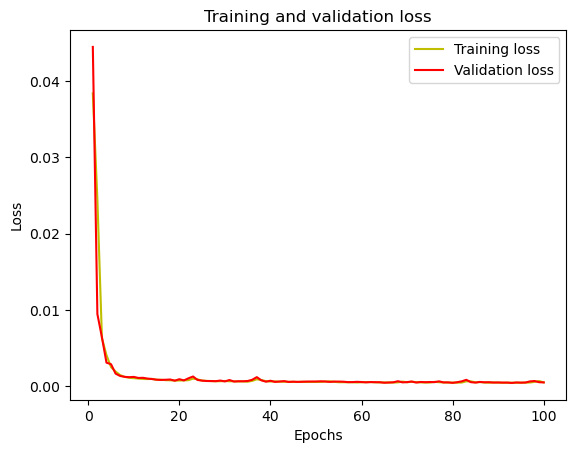

In [31]:
# Plot training and validation loss
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'y', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


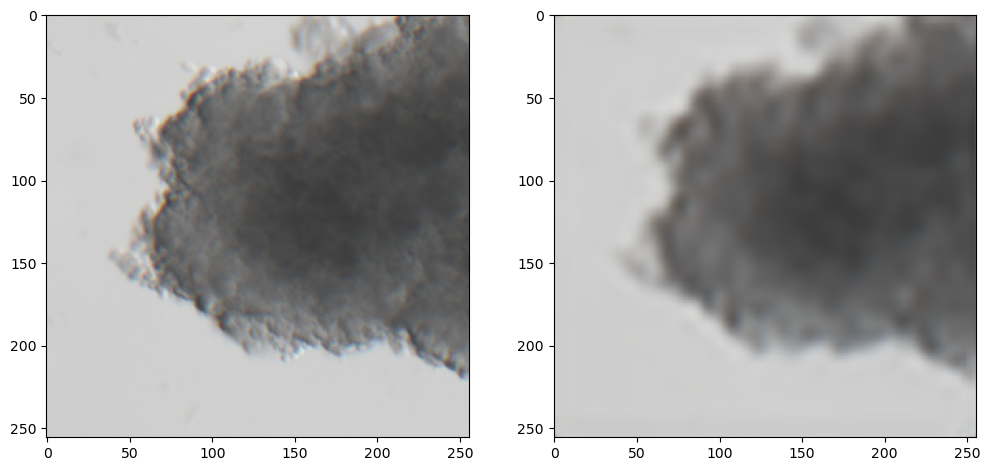

In [33]:
# Testing on a batch of images
data_batch = next(iter(train_loader))
images = data_batch
mode.eval()
with torch.no_grad():
    outputs = mode(images)

# Display original and reconstructed images
image_number = random.randint(0, outputs.shape[0] - 1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.transpose(images[image_number].numpy(), (1, 2, 0)))
plt.subplot(122)
plt.imshow(np.transpose(outputs[image_number].numpy(), (1, 2, 0)))
plt.show()

In [40]:
# Training the model
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()  # Start time for the epoch
    
    modeling.train()
    train_loss = 0
    for images in train_loader:
        optimizer.zero_grad()
        outputs = modeling(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    modeling.eval()
    val_loss = 0
    with torch.no_grad():
        for images in val_loader:
            outputs = modeling(images)
            loss = criterion(outputs, images)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    end_time = time.time()  # End time for the epoch
    epoch_time = end_time - start_time  # Calculate epoch duration
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')


Epoch [1/50], Train Loss: 0.0362, Validation Loss: 0.0359, Time: 14.04 seconds
Epoch [2/50], Train Loss: 0.0158, Validation Loss: 0.0103, Time: 13.99 seconds
Epoch [3/50], Train Loss: 0.0054, Validation Loss: 0.0033, Time: 13.84 seconds
Epoch [4/50], Train Loss: 0.0038, Validation Loss: 0.0029, Time: 13.88 seconds
Epoch [5/50], Train Loss: 0.0024, Validation Loss: 0.0024, Time: 13.87 seconds
Epoch [6/50], Train Loss: 0.0019, Validation Loss: 0.0019, Time: 13.86 seconds
Epoch [7/50], Train Loss: 0.0015, Validation Loss: 0.0020, Time: 13.81 seconds
Epoch [8/50], Train Loss: 0.0014, Validation Loss: 0.0015, Time: 13.91 seconds
Epoch [9/50], Train Loss: 0.0012, Validation Loss: 0.0013, Time: 13.44 seconds
Epoch [10/50], Train Loss: 0.0011, Validation Loss: 0.0011, Time: 13.66 seconds
Epoch [11/50], Train Loss: 0.0011, Validation Loss: 0.0010, Time: 13.78 seconds
Epoch [12/50], Train Loss: 0.0009, Validation Loss: 0.0010, Time: 13.95 seconds
Epoch [13/50], Train Loss: 0.0009, Validation Los

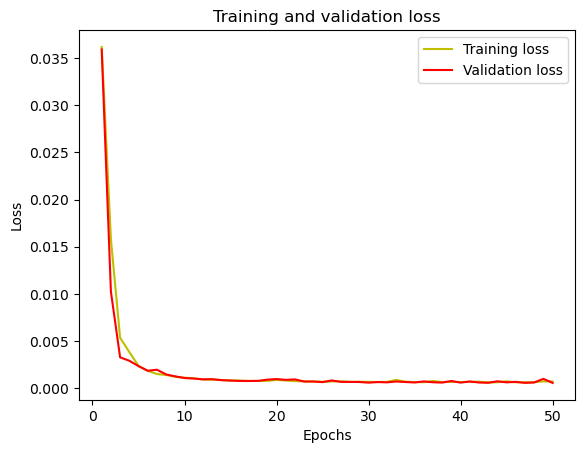

In [41]:
# Plot training and validation loss
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'y', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


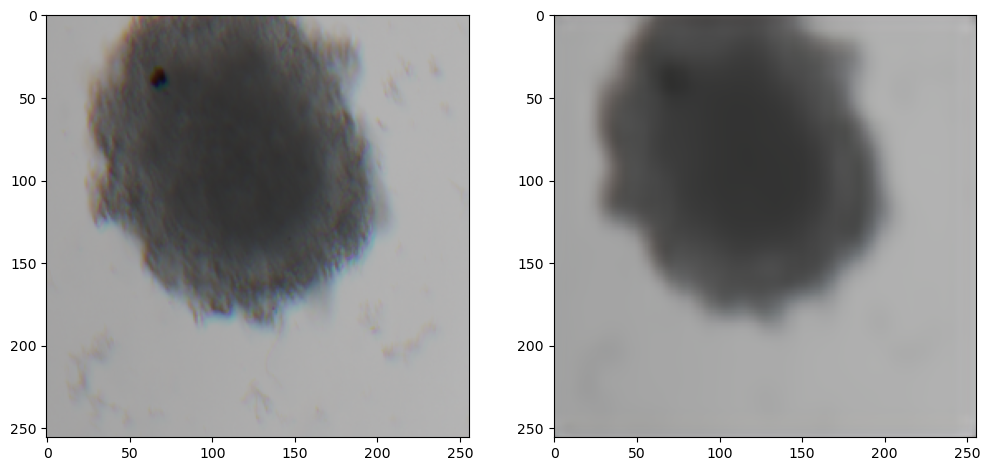

In [42]:
# Testing on a batch of images
data_batch = next(iter(train_loader))
images = data_batch
modeling.eval()
with torch.no_grad():
    outputs = modeling(images)

# Display original and reconstructed images
image_number = random.randint(0, outputs.shape[0] - 1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.transpose(images[image_number].numpy(), (1, 2, 0)))
plt.subplot(122)
plt.imshow(np.transpose(outputs[image_number].numpy(), (1, 2, 0)))
plt.show()

In [31]:
# Training the model
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()  # Start time for the epoch
    
    model.train()
    train_loss = 0
    for images in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images in val_loader:
            outputs = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    end_time = time.time()  # End time for the epoch
    epoch_time = end_time - start_time  # Calculate epoch duration
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')


Epoch [1/100], Train Loss: 0.0021, Validation Loss: 0.0024, Time: 9.77 seconds
Epoch [2/100], Train Loss: 0.0023, Validation Loss: 0.0020, Time: 9.86 seconds
Epoch [3/100], Train Loss: 0.0019, Validation Loss: 0.0015, Time: 10.60 seconds
Epoch [4/100], Train Loss: 0.0017, Validation Loss: 0.0013, Time: 17.64 seconds
Epoch [5/100], Train Loss: 0.0016, Validation Loss: 0.0014, Time: 17.35 seconds
Epoch [6/100], Train Loss: 0.0016, Validation Loss: 0.0016, Time: 11.54 seconds
Epoch [7/100], Train Loss: 0.0015, Validation Loss: 0.0013, Time: 14.38 seconds
Epoch [8/100], Train Loss: 0.0014, Validation Loss: 0.0013, Time: 17.61 seconds
Epoch [9/100], Train Loss: 0.0014, Validation Loss: 0.0014, Time: 17.50 seconds
Epoch [10/100], Train Loss: 0.0014, Validation Loss: 0.0010, Time: 17.55 seconds
Epoch [11/100], Train Loss: 0.0012, Validation Loss: 0.0012, Time: 17.33 seconds
Epoch [12/100], Train Loss: 0.0012, Validation Loss: 0.0011, Time: 11.44 seconds
Epoch [13/100], Train Loss: 0.0012, Val

In [35]:
# Save the model parameters after training
torch.save(model.state_dict(), 'model.pth')


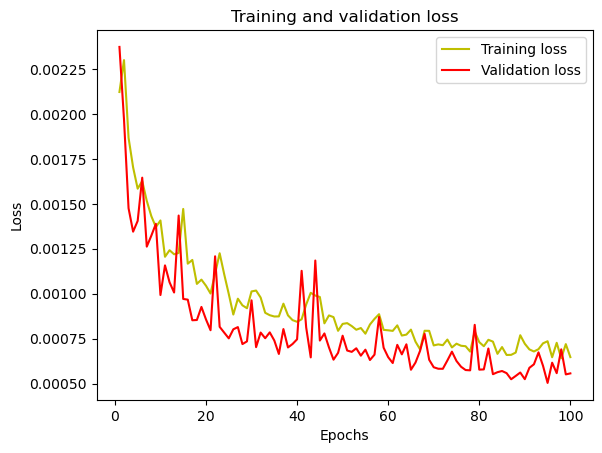

In [33]:
# Plot training and validation loss
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'y', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


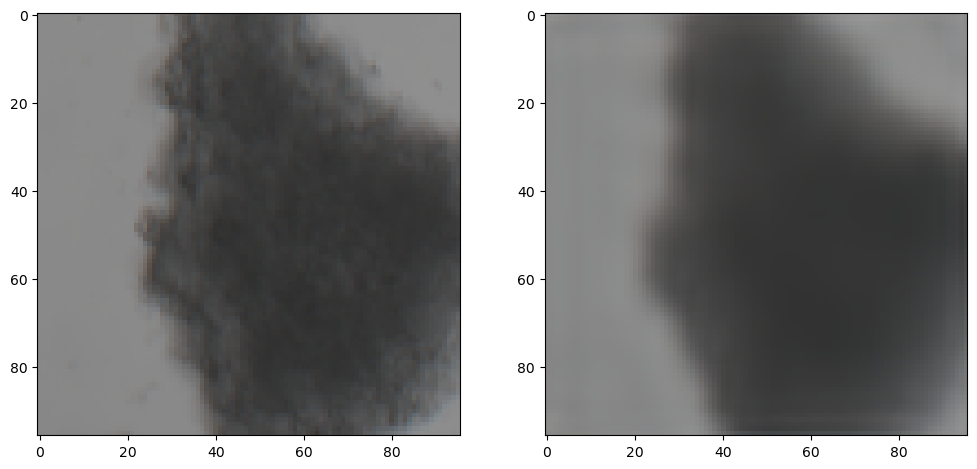

In [34]:
# Testing on a batch of images
data_batch = next(iter(train_loader))
images = data_batch
model.eval()
with torch.no_grad():
    outputs = model(images)

# Display original and reconstructed images
image_number = random.randint(0, outputs.shape[0] - 1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.transpose(images[image_number].numpy(), (1, 2, 0)))
plt.subplot(122)
plt.imshow(np.transpose(outputs[image_number].numpy(), (1, 2, 0)))
plt.show()

In [ ]:
# Evaluate reconstruction error for validation and anomaly datasets
def evaluate_reconstruction_error(data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, _ in data_loader:
            outputs = model(images)
            loss = criterion(outputs, images)
            total_loss += loss.item()
    return total_loss / len(data_loader)

validation_error = evaluate_reconstruction_error(validation_loader)
anomaly_error = evaluate_reconstruction_error(anomaly_loader)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)

In [ ]:

#Fit the model. 
history = model.fit(
        train_generator,
        steps_per_epoch= 500 // batch_size,
        epochs=1000,
        validation_data=validation_generator,
        validation_steps=75 // batch_size,
        shuffle = True)


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Get all batches generated by the datagen and pick a batch for prediction
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

predicted = model.predict(data_batch[0])  #Predict on the first batch of images


#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

#Let us examine the reconstruction error between our validation data (good/normal images)
# and the anomaly images
validation_error = model.evaluate_generator(validation_generator)
anomaly_error = model.evaluate_generator(anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)








#We use these mean and sigma to set thresholds. 
def calc_recon_error(batch_images):
    
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        
        recon_error_list.append(reconstruction_error)
        
   
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return  average_recon_error, stdev_recon_error

#Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images. 
#For this let us generate a batch of images for each. 
train_batch = train_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

uninfected_values = calc_recon_error(train_batch)
anomaly_values = calc_recon_error(anomaly_batch)


#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
     #Set this value based on the above exercise
    reconstruction_error_threshold = 0.004 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
        
    else:
        print("The image is NOT an anomaly")
        
        
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
para_file_paths = glob.glob('cell_images2/parasitized/images/*')
uninfected_file_paths = glob.glob('cell_images2/uninfected_train/images/*')

#Anomaly image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(para_file_paths[num])

#Good/normal image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(uninfected_file_paths[num])

In [ ]:
#mandatharam data aug add

In [ ]:
# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None,augment_transform=None):
        self.image_dir = image_dir
        self.transform = transform  # Transformation for original images
        self.augment_transform = augment_transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)
        #print(image.shape)
        #image = np.expand_dims(image, axis=0)
        #print(image.shape)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:                                                       #change to 1 for single channel image
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply transformations
        orig_image = self.transform(image)  # Apply transform for original images
        aug_image = self.augment_transform(image)  # Apply augmentation
            
        
        return orig_image, aug_image  # Return original image

# Transformation for original images (only resize)
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=256),  # Resize original image to 256x256
])

# Transformation for augmented images (with additional augmentation)
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(size=256),  # Resize augmented image to 256x256
])

# Dataset for original images (without augmentations)
image_dir = r"../../Day10_drugscreened&singledose_untreated"

dataset = ImageDataset(image_dir=image_dir, transform=transform,augment_transform=augment_transform)

# List to hold all images (original + augmented)
all_images = []

for orig_image, aug_image in dataset:
    # Add the original image and augmented image to the list
    all_images.append(orig_image)
    all_images.append(aug_image)

# Now all_images contains both original and augmented images in a flat list
print(f"Total number of images: {len(all_images)}")



In [ ]:
class SimpleImageDataset(Dataset):
    def __init__(self, image_list):
        self.image_list = image_list

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        return self.image_list[idx]

# Now, create a DataLoader using the combined list
combined_dataset = SimpleImageDataset(all_images)

In [ ]:
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(combined_dataset, val_percentage):
    val_size = int(len(combined_dataset) * val_percentage)
    train_size = len(combined_dataset) - val_size
    return random_split(combined_dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(combined_dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)